# Analysis of ENSO predictability

In [1]:
import re
import os
import dask
import glob
import scipy
import doppyo
import random
import sklearn
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
from mord import LogisticAT
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from matplotlib.collections import LineCollection

# Notebook specific -----
%matplotlib inline
xr.set_options(display_style="html");

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/active_projects/paper_Risbey_Nature_ENSO/figures/'

# Spin up a cluster

In [221]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(walltime='2:00:00', cores=8, memory='6GB', job_extra=['--qos="express"'])

In [222]:
cluster.scale(n=6)

In [224]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://152.83.81.91:41169 Dashboard: http://152.83.81.91:46443/status,Cluster Workers: 4 Cores: 32 Memory: 24.00 GB


# Notebook-specific functions

In [7]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [8]:
def get_nino34_observation_anomalies(da_ts, save_name, nino_already=False, compute=False, save_chunks=None):
    if compute:
        full_period = slice('1982','2015')
        train_period = slice('1982','1998')
        test_period = slice('1999','2015')
        stack_dates = pd.date_range('1982-01','2015-12', freq='MS')
        
        # Get full nino34 -----
        if nino_already:
            nino34_ts = da_ts.to_dataset(name='full')
        else:
            nino34_ts = doppyo.diagnostic.nino34(da_ts).to_dataset(name='full')
        nino34 = doppyo.utils.stack_by_init_date(nino34_ts['full'], 
                                                 init_dates=stack_dates, 
                                                 N_lead_steps=12).to_dataset(name='full')
        
        # Get biased anomalies -----
        clim_period = train_period
        nino34_ts['biased'] = (nino34_ts['full'].groupby('time.month') - 
                               nino34_ts['full'].sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
        nino34['biased'] = doppyo.utils.stack_by_init_date(nino34_ts['biased'], 
                                                           init_dates=stack_dates,
                                                           N_lead_steps=12)
        
        # Get unfair anomalies -----
        clim_period = test_period
        nino34_ts['unfair'] = (nino34_ts['full'].groupby('time.month') - 
                               nino34_ts['full'].sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
        nino34['unfair'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair'], 
                                                           init_dates=stack_dates, 
                                                           N_lead_steps=12)
        
        # Get unfair-cv anomalies -----
        clim_period = test_period
        clim_use = nino34_ts['full'].sel(time=clim_period)
        nino34_ts['unfair-cv:1yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=1, 
                                                                             time_dim='time')
        nino34['unfair-cv:1yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:1yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=12).drop('month')
        nino34_ts['unfair-cv:3yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=3, 
                                                                             time_dim='time')
        nino34['unfair-cv:3yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:3yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=12).drop('month')
        nino34_ts['unfair-cv:5yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=5, 
                                                                             time_dim='time')
        nino34['unfair-cv:5yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:5yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=12).drop('month')
        nino34_ts['unfair-cv:7yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                             clim_ts=clim_use, 
                                                                             leave_out_years=7, 
                                                                             time_dim='time')
        nino34['unfair-cv:7yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-cv:7yr'], 
                                                                  init_dates=stack_dates, 
                                                                  N_lead_steps=12).drop('month')
        
        # Get fair anomalies -----
        nino34_ts['fair'] = nino34_ts['biased']
        nino34['fair'] = nino34['biased']

        # Get fair-sliding anomalies -----
        clim_use = nino34_ts['full']
        nino34_ts['fair-sliding'] = nino34_ts['full'].sel(time=test_period).groupby('time').apply(slide_anomalize, 
                                                                                                  clim_ts=clim_use, 
                                                                                                  time_dim='time')
        nino34['fair-sliding'] = doppyo.utils.stack_by_init_date(nino34_ts['fair-sliding'], 
                                                                 init_dates=stack_dates, 
                                                                 N_lead_steps=12).drop('month')
        
        # Get fair-all anomalies -----
        clim_use = nino34_ts['full']
        nino34_ts['fair-all'] = nino34_ts['full'].sel(time=test_period).groupby('time').apply(slide_anomalize, 
                                                                                              clim_ts=clim_use, 
                                                                                              clim_period=None, 
                                                                                              time_dim='time')
        nino34['fair-all'] = doppyo.utils.stack_by_init_date(nino34_ts['fair-all'], 
                                                             init_dates=stack_dates, 
                                                             N_lead_steps=12).drop('month')

        # Get fair* anomalies -----
        nino34_ts['fair*'] = nino34_ts['biased']
        nino34['fair*'] = nino34['biased']

        # Get unfair-full anomalies -----
        clim_period = full_period
        clim_use = nino34_ts['full'].sel(time=clim_period)
        nino34_ts['unfair-all-cv:1yr'] = nino34_ts['full'].groupby('time').apply(cv_anomalize, 
                                                                                  clim_ts=clim_use,
                                                                                  leave_out_years=1,
                                                                                  time_dim='time')
        nino34['unfair-all-cv:1yr'] = doppyo.utils.stack_by_init_date(nino34_ts['unfair-all-cv:1yr'], 
                                                                       init_dates=stack_dates, 
                                                                       N_lead_steps=12).drop('month')

        nino34.chunk(save_chunks).to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
        
    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [9]:
def get_nino34_forecast_anomalies(da, observations, save_name, compute=False, save_chunks=None):
    if compute:
        full_period = slice('1982','2015')
        train_period = slice('1982','1998')
        test_period = slice('1999','2015')
        
        # Get full nino34 -----
        nino34 = doppyo.diagnostic.nino34(da).to_dataset(name='full')
        
        # Get biased anomalies -----
        clim_period = train_period
        clim_biased = observations['full'].sel(init_date=clim_period, lead_time=0) \
                                          .groupby('init_date.month').mean('init_date').drop('lead_time')
        nino34['biased'] = nino34['full'].groupby('init_date').apply(lambda_anomalize, clim=clim_biased)
        
        # Get unfair anomalies -----
        clim_period = test_period
        clim_unfair = nino34['full'].sel(init_date=clim_period) \
                                    .groupby('init_date.month').mean(['init_date','ensemble'])
        nino34['unfair'] = (nino34['full'].groupby('init_date.month') - clim_unfair)
        
        # Get unfair-cv anomalies -----
        clim_period = test_period
        nino34_full_use = nino34['full'].sel(init_date=clim_period).mean('ensemble')
        nino34['unfair-cv:1yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=1)
        nino34['unfair-cv:3yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=3)
        nino34['unfair-cv:5yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=5)
        nino34['unfair-cv:7yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                            clim_ts=nino34_full_use, 
                                                                            leave_out_years=7)
        
        # Get fair anomalies -----
        clim_period = train_period
        clim_fair = nino34['full'].sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
        nino34['fair'] = nino34['full'].groupby('init_date.month') - clim_fair
        
        # Get fair-sliding anomalies -----
        clim_fairsliding = nino34['full'].mean('ensemble')
        nino34['fair-sliding'] = nino34['full'].sel(init_date=test_period) \
                                               .groupby('init_date').apply(slide_anomalize, 
                                                                           clim_ts=clim_fairsliding)
        
        # Get fair-all anomalies -----
        clim_fairall = nino34['full'].mean('ensemble')
        nino34['fair-all'] = nino34['full'].sel(init_date=test_period) \
                                           .groupby('init_date').apply(slide_anomalize, 
                                                                       clim_ts=clim_fairall, 
                                                                       clim_period=None)

        # Get fair* anomalies -----
        clim_period = train_period
        init_dates = nino34['biased'].sel(init_date=clim_period).init_date.copy()
        lead_times = nino34['biased'].sel(init_date=clim_period).lead_time.copy()
        init_dates.values = np.arange(len(init_dates))
        mask = (init_dates + lead_times) <= init_dates[-1]
        fcst_er = (nino34['biased'].where(mask) - observations['biased'].where(mask)).groupby('init_date.month') \
                                                                                     .mean(['init_date','ensemble'])
        nino34['fair*'] = (nino34['biased'].groupby('init_date.month') - fcst_er)

        # Get unfair-full anomalies -----
        clim_period = full_period
        nino34_full_use = nino34['full'].sel(init_date=clim_period).mean('ensemble')
        nino34['unfair-all-cv:1yr'] = nino34['full'].groupby('init_date').apply(cv_anomalize, 
                                                                                 clim_ts=nino34_full_use,
                                                                                 leave_out_years=1)

        nino34.chunk(save_chunks).to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
        
    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [10]:
def get_regressions(x, y, save_name, model, compute=False, save_chunks=None):
    if compute:
        train_period = slice('1982','1998')
        test_period = slice('1999','2015')
        full_period = slice('1982','2015')
        
        reg_nino34 = regress(x['biased'].sel(init_date=test_period, lead_time=0),
                             x['biased'].sel(init_date=train_period, lead_time=0),
                             y['biased'].sel(init_date=train_period, lead_time=slice(1,11)),
                             model).to_dataset(name='biased')
        
        reg_nino34['unfair-cv:1yr'] = x['unfair-cv:1yr'].sel(init_date=test_period).sel(lead_time=0, drop=True) \
                                                        .groupby('init_date') \
                                                        .apply(regress, 
                                                               x_train=x['unfair-cv:1yr'].sel(init_date=test_period, 
                                                                                              lead_time=0), 
                                                               y_train=y['unfair-cv:1yr'].sel(init_date=test_period, 
                                                                                              lead_time=slice(1,11)),
                                                               model=model)
        
        reg_nino34['unfair'] = x['unfair'].sel(init_date=test_period).sel(lead_time=0, drop=True) \
                                          .groupby('init_date') \
                                          .apply(regress, 
                                                 x_train=x['unfair'].sel(init_date=test_period, 
                                                                         lead_time=0), 
                                                 y_train=y['unfair'].sel(init_date=test_period, 
                                                                         lead_time=slice(1,11)),
                                                 model=model, cv=False)

        reg_nino34['fair'] = reg_nino34['biased']

        reg_nino34['fair-sliding'] = x['fair'].sel(init_date=test_period).sel(lead_time=0, drop=True) \
                                              .groupby('init_date') \
                                              .apply(sliding_regress, 
                                                     x_train=x['fair'].sel(init_date=full_period, 
                                                                           lead_time=0), 
                                                     y_train=y['fair'].sel(init_date=full_period, 
                                                                           lead_time=slice(1,11)),
                                                     model=model)

        reg_nino34['fair-all'] = x['fair'].sel(init_date=test_period).sel(lead_time=0, drop=True) \
                                          .groupby('init_date') \
                                          .apply(sliding_regress, 
                                                 x_train=x['fair'].sel(init_date=full_period, 
                                                                       lead_time=0), 
                                                 y_train=y['fair'].sel(init_date=full_period, 
                                                                       lead_time=slice(1,11)),
                                                 model=model,
                                                 train_period=None)

        reg_nino34['fair*'] = reg_nino34['biased']

        reg_nino34['unfair-all-cv:1yr'] = x['unfair-all-cv:1yr'].sel(init_date=full_period).sel(lead_time=0, drop=True) \
                                                                  .groupby('init_date') \
                                                                  .apply(regress, 
                                                                         x_train=x['unfair-all-cv:1yr'].sel(init_date=full_period, 
                                                                                                             lead_time=0), 
                                                                         y_train=y['unfair-all-cv:1yr'].sel(init_date=full_period, 
                                                                                                             lead_time=slice(1,11)),
                                                                         model=model)
        
        reg_nino34.chunk(save_chunks).to_zarr(tmp_dir + save_name + '.zarr', mode='w', consolidated=True) 
        
    return xr.open_zarr(tmp_dir + save_name + '.zarr', consolidated=True)

In [11]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [12]:
def cv_anomalize(fcst, clim_ts, leave_out_years=1, time_dim = 'init_date'):
    """ Anomalize provided data in a "cross-validated" manner """
    
    if (leave_out_years % 2) == 0:
        raise ValueError('leave_out_years must be odd')
    
    span = (leave_out_years - 1) / 2
    
    fcst_year = fcst[time_dim].dt.year.item()
    remove_years = np.arange(fcst_year-span, fcst_year+span+1)
    
    clim_dates = clim_ts[time_dim].values
    if not hasattr(clim_dates, "__iter__"):
        clim_dates = [clim_dates]
        
    dates_2_use = [date for date in clim_dates if pd.to_datetime(date).year not in remove_years]
    clim = clim_ts.sel({time_dim : dates_2_use}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [13]:
def slide_anomalize(fcst, clim_ts, clim_period=17, time_dim='init_date'):
    """ 
        Anomalize provided data using the climatology averaged over the period ranging from 
        clim_period+1 years before to 1 year before the data being anomalized 
        set clim_period=None to use all clim_ts data up to fcst date
    """
    end_date = fcst[time_dim].values
    if clim_period is None:
        start_date = clim_ts[time_dim].isel({time_dim : 0}).values
    else:
        start_date = doppyo.sugar.year_delta(end_date, delta=-clim_period)
    clim_range = slice(start_date, end_date)

    clim = clim_ts.sel({time_dim : clim_range}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [14]:
def regress(x_predict, x_train, y_train, model, cv=True):
    """ 
        Build model per calendar model and lead over dates in da_predict using data in da_train
        If cv=True, overlapping periods in da_predict and da_train are excluded from the training period
    """
    
    def _fit(x_train, y_train, model):
        return doppyo.utils.fit(x_train, y_train.sel(init_date=x_train.init_date.values), model=model, over_dims='init_date')
    
    def _predict(x_predict, p):
        month = x_predict.init_date.dt.month.values[0]
        return doppyo.utils.predict(x_predict, p.sel(month=month, drop=True), over_dims='init_date')

    if x_predict.shape == ():
        x_predict = x_predict.expand_dims('init_date')
    x_predict = doppyo.utils.prune(x_predict)
    
    train_dates = x_train['init_date'].values
    if not hasattr(train_dates, "__iter__"):
        train_dates = [train_dates]
    predict_dates = x_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]
    
    if cv:
        train_dates = sorted(set(train_dates) - set(predict_dates))
        
    x_train_no = x_train.sel({'init_date' : train_dates})
    y_train_no = y_train.sel({'init_date' : train_dates})
    
    p = x_train_no.groupby('init_date.month').apply(_fit, y_train=y_train_no, model=model)
    
    if len(predict_dates) == 1:
        return _predict(x_predict, p=p).squeeze()
    else:
        return x_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [15]:
def sliding_regress(x_predict, x_train, y_train, model, train_period=17, time_dim='init_date'):
    """ 
        Build model per calendar model and lead over dates in da_predict using data in da_train
        The period immediately prior to the forecast data is used for training
        Set train_period = None to use all available training data
    """
    
    def _fit(x_train, y_train, model):
        return doppyo.utils.fit(x_train, y_train.sel(init_date=x_train.init_date.values), model=model, over_dims='init_date')
    
    def _predict(x_predict, p):
        month = x_predict.init_date.dt.month.values[0]
        return doppyo.utils.predict(x_predict, p.sel(month=month, drop=True), over_dims='init_date')

    if x_predict.shape == ():
        x_predict = x_predict.expand_dims('init_date')
    x_predict = doppyo.utils.prune(x_predict)
    
    end_date = x_predict[time_dim].values[0]
    if train_period is None:
        start_date = x_train[time_dim].isel({time_dim : 0}).values
    else:
        start_date = doppyo.sugar.year_delta(end_date, delta=-train_period)

    train_dates = slice(start_date, end_date)
    predict_dates = x_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]

    x_train_no = x_train.sel({'init_date' : train_dates})
    y_train_no = y_train.sel({'init_date' : train_dates})
    
    p = x_train_no.groupby('init_date.month').apply(_fit, y_train=y_train_no, model=model)
    
    if len(predict_dates) == 1:
        return _predict(x_predict, p=p).squeeze()
    else:
        return x_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [16]:
def where_elninos(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_elnino = da.rolling(init_date=3, center=True).mean() > 0.5
    where_elnino.values = scipy.ndimage.measurements.label(1*where_elnino, structure=s)[0]
    
    return where_elnino

In [17]:
def where_laninas(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_lanina = da.rolling(init_date=3, center=True).mean() < -0.5
    where_lanina.values = scipy.ndimage.measurements.label(1*where_lanina, structure=s)[0]
    
    return where_lanina

In [18]:
def get_ENSO_events(nino34):
    "If input is a dictionary, applies to all elements of dictionary and returns dictionary "
    if 'full' in nino34:
        nino34 = nino34.copy().drop('full')
        
    if isinstance(nino34, dict):
        where_elnino = {}; where_lanina = {}; where_event = {}
        for key in nino34.keys():
            where_elnino[key] = nino34[key].apply(where_elninos)
            where_lanina[key] = nino34[key].apply(where_laninas)
            where_event[key] = (where_elnino[key].where(where_elnino[key]==0, other=1) - 
                                where_lanina[key].where(where_lanina[key]==0, other=1))
    else:
        where_elnino = nino34.apply(where_elninos)
        where_lanina = nino34.apply(where_laninas)
        where_event = (where_elnino.where(where_elnino==0, other=1) - 
                       where_lanina.where(where_lanina==0, other=1))
    return where_elnino, where_lanina, where_event

In [19]:
def where_condition_events(where_event, method):

    for event_id in range(1, where_event.max().values+1):
        specific_event = 1*(where_event == event_id)

        if method == 'decay':
            specific_event = -1 * (specific_event - 1)

        int_event = doppyo.utils.integrate(specific_event, over_dim='lead_time', 
                                            x=(1+0*specific_event.lead_time.astype(int)).cumsum('lead_time'), 
                                            method='rect', cumulative=True)
        int_cmpar = (1+0*specific_event.astype(int)).cumsum('lead_time')

        specific_event_conditioned = specific_event.where(int_event != int_cmpar, other=0)
        
        if method == 'decay':
            specific_event_conditioned = specific_event_conditioned.where(specific_event.sel(lead_time=0) == 0, other=0)
            
        if event_id == 1:
            event_conditioned = specific_event_conditioned
        else:
            event_conditioned = event_conditioned + specific_event_conditioned
            
    return event_conditioned

In [20]:
def get_ENSO_onset_and_decay(where_elnino, where_lanina):
    "If input is a dictionary, applies to all elements of dictionary and returns dictionary "
    if isinstance(where_elnino, dict):
        where_elnino_onset = {}; where_lanina_onset = {}
        where_elnino_decay = {}; where_lanina_decay = {}
        for key in nino34.keys():
            where_elnino_onset[key] = where_elnino[key].apply(where_condition_events, method='onset')
            where_lanina_onset[key] = where_lanina[key].apply(where_condition_events, method='onset')
            where_elnino_decay[key] = where_elnino[key].apply(where_condition_events, method='decay')
            where_lanina_decay[key] = where_lanina[key].apply(where_condition_events, method='decay')
    else:
        where_elnino_onset = where_elnino.apply(where_condition_events, method='onset')
        where_lanina_onset = where_lanina.apply(where_condition_events, method='onset')
        where_elnino_decay = where_elnino.apply(where_condition_events, method='decay')
        where_lanina_decay = where_lanina.apply(where_condition_events, method='decay')
    return where_elnino_onset, where_lanina_onset, where_elnino_decay, where_lanina_decay

In [21]:
def plot_fcst(t, x, ax=None, cmap='jet', **kwargs):
    # Convert dates to numbers first ---- 
    try:
        inxval = mpl.dates.date2num(t.to_index().to_pydatetime())
        points = np.array([inxval, x.values]).T.reshape(-1,1,2)
    except:
        inxval = mpl.dates.date2num(t)
        points = np.array([inxval, x]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, **kwargs)
    lc.set_array(inxval)
    
    monthFmt = mpl.dates.DateFormatter("%Y")
    if ax is None:
        ax = plt.gca()
        
    ax.add_collection(lc)
    ax.xaxis.set_major_formatter(monthFmt)
    ax.autoscale_view()
    ax.xaxis_date()

In [22]:
def init_date_to_target_date(da, init_date_coord='init_month', lead_time_coord='lead_time'):
    """ 
    Convert from initial date format to target date format 
    Note : this function only works when initial date and lead time are matching frequencies
    """
    new = []
    for lead in da[lead_time_coord]:
        rolled = da.copy().sel({lead_time_coord : lead.values}).roll(**{init_date_coord : lead.values})
        rolled = rolled.assign_coords({init_date_coord: da[init_date_coord].values})
        new.append(rolled)

    return xr.concat(new, dim=lead_time_coord).rename({init_date_coord : init_date_coord.replace('init','target')})

In [23]:
def monthly_climatology(da, time_dim='init_date'):
    if 'ensemble' in da.dims:
        return da.groupby('init_date.month').mean(['init_date', 'ensemble'])
    else:
        return da.groupby('init_date.month').mean('init_date')

In [208]:
def random_ensemble_mean(da, j):
    random_ensembles = random.choices(da.ensemble.values, k=j)

    return da.sel(ensemble = random_ensembles).mean('ensemble')

def random_sample_skill_metric(da_cmp, da_ref, skill_metric, n=None, j=None, skill_metric_kwargs=None):
    """
        Bootstrap a skill metric
            n = number of initial dates to sample
            j = number of ensembles to sample. If None, don't bootstrap ensemble
    """
    if n:
        random_starts = sorted(random.choices(da_cmp.init_date.values, k=n))
    else:
        random_starts = sorted(da_cmp.init_date.values)
        n = len(random_starts)
    
    da_cmp_random_starts = da_cmp.copy().sel(init_date=random_starts)
    da_cmp_random_starts['init_date'] = np.arange(n)
    if j:
        da_cmp_bootstrap = da_cmp_random_starts.groupby('init_date').apply(random_ensemble_mean, j=j)
    else:
        if 'ensemble' in da_cmp_random_starts.dims:
            da_cmp_bootstrap = da_cmp_random_starts.mean('ensemble')
        else:
            da_cmp_bootstrap = da_cmp_random_starts
    da_ref_bootstrap = da_ref.copy().sel(init_date=random_starts)
    da_ref_bootstrap['init_date'] = np.arange(n)
    
    return skill_metric(da_cmp_bootstrap, da_ref_bootstrap, **skill_metric_kwargs)

In [209]:
def get_Gerrity_score(da_cmp, da_ref, category_edges_cmp, category_edges_ref, over_dims):
    _,_,cmp_where_event = get_ENSO_events(da_cmp.to_dataset(name='ds'))
    _,_,ref_where_event = get_ENSO_events(da_ref.to_dataset(name='ds'))
    
    contingency = doppyo.skill.contingency(cmp_where_event['ds'], ref_where_event['ds'], 
                                           category_edges_cmp, category_edges_ref, over_dims)
    
    return doppyo.skill.Gerrity_score(contingency)

In [210]:
def get_MSS_score(da_cmp, da_ref, reference_MSE, over_dims):
    MSE = doppyo.skill.mean_squared_error(da_cmp, da_ref, over_dims=over_dims)
    #MSE_o = doppyo.skill.mean_squared_error(clim_cmp, da_ref, over_dims=over_dims)

    return 1 - ( MSE / reference_MSE )

In [211]:
def bootstrap_skill_metric(da_cmp, da_ref, skill_metric, k, n, j=None, skill_metric_kwargs=None, with_dask=True):
    """
        Bootstrap a skill metric
            k = number of bootstraps
            n = number of initial dates to sample
            j = number of ensembles to sample. If None, don't bootstrap ensemble
    """
    if with_dask:
        random_sample_skill_metric_ = dask.delayed(random_sample_skill_metric)
        bs_list = [random_sample_skill_metric_(
                      da_cmp=da_cmp,
                      da_ref=da_ref,
                      skill_metric=skill_metric,
                      n=n,
                      j=j,
                      skill_metric_kwargs=skill_metric_kwargs) for _ in range(k)]
        return xr.concat(dask.compute(bs_list)[0], dim='k')
    else:
        bs_list = []
        for _ in range(k):
            bs_list.append(random_sample_skill_metric(
                da_cmp=da_cmp,
                da_ref=da_ref,
                skill_metric=skill_metric,
                n=n,
                j=j,
                skill_metric_kwargs=skill_metric_kwargs))
        return xr.concat(bs_list, dim='k')

# A note about climatologies and bias corrections
The CMC Can3/4 hindcasts / forecasts span the periods 1981-01 -> 2010-12 / 2011-01 -> 2018-09. The GFDL and COLA models span 1982-01 -> 2018-11. The Hadley ISST data spans 1870-01 -> 2018-02.
The mutual span of these datasets is **1982-01 -> 2018-02**

In this notebook we compare and contrast a number of methods for computing anomalies and for bias correcting data. In all cases, **17 years of data are use to build climatologies**.

# Load the data

In [24]:
zarr_dir = '/scratch1/projects/dcfp/data/'
tmp_dir = '/scratch1/squ027/tmp/ENSO_NatComms.'

#### NOAA OISST data (taken from http://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices)

In [25]:
oisst_nino34_full_ts = xr.DataArray(np.loadtxt('OISST_NINO34_198201-201902.txt', delimiter=','), 
                                    coords=[('time', 
                                             pd.date_range(start='1982-01',end='2019-02',freq='MS'))])

oisst_nino34 = get_nino34_observation_anomalies(oisst_nino34_full_ts, 
                                                save_name='oisst_nino34',
                                                nino_already=True,
                                                compute=False,
                                                save_chunks={'init_date': -1,
                                                             'lead_time': -1}).compute()

#### Hadley ISST data

In [26]:
zarr_collection = 'csiro-dcfp-hadisst'
had_sst_full_ts = doppyo.utils.trunc_time(xr.open_zarr(zarr_dir + zarr_collection + '/hadisst_month.zarr', 
                                                       consolidated=True)['sst'] \
                                            .rename({'longitude' : 'lon', 'latitude' : 'lat'}),
                                          freq='M')

had_nino34 = get_nino34_observation_anomalies(had_sst_full_ts,
                                              save_name='had_nino34',
                                              nino_already=False,
                                              compute=False,
                                              save_chunks={'init_date': -1,
                                                           'lead_time': -1}).compute()

## Choose which obs to use

In [27]:
obs_nino34 = oisst_nino34 #had_nino34

#### COLA-RSMAS-CCSM4 data

In [28]:
zarr_collection = 'csiro-dcfp-nmme_p1-cola_rsmas_ccsm4'
cola_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

cola_nino34 = get_nino34_forecast_anomalies(cola_sst_raw,
                                            observations=obs_nino34,
                                            save_name='cola_nino34', 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

#### GFDL-CM2p1-aer04 data

In [29]:
zarr_collection = 'csiro-dcfp-nmme_p1-gfdl_cm2p1_aer04'
aer04_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

aer04_nino34 = get_nino34_forecast_anomalies(aer04_sst_raw,
                                             observations=obs_nino34,
                                             save_name='aer04_nino34', 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

#### GFDL-CM2p5-FLOR-A06 data

In [30]:
zarr_collection = 'csiro-dcfp-nmme_p1-gfdl_cm2p5_flor_a06'
florA_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

florA_nino34 = get_nino34_forecast_anomalies(florA_sst_raw,
                                             observations=obs_nino34,
                                             save_name='florA_nino34', 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

#### GFDL-CM2p5-FLOR-B01 data

In [31]:
zarr_collection = 'csiro-dcfp-nmme_p1-gfdl_cm2p5_flor_b01'
florB_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

florB_nino34 = get_nino34_forecast_anomalies(florB_sst_raw,
                                             observations=obs_nino34,
                                             save_name='florB_nino34', 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

#### CMC CanCM3 data

In [32]:
zarr_collection = 'csiro-dcfp-nmme_p1-cmc_cancm3'
cm3_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

cm3_nino34 = get_nino34_forecast_anomalies(cm3_sst_raw,
                                           observations=obs_nino34,
                                           save_name='cm3_nino34', 
                                           compute=False,
                                           save_chunks = {'lead_time': -1,
                                                          'init_date': -1,
                                                          'ensemble': -1}).compute()

#### CMC CanCM4 data

In [33]:
zarr_collection = 'csiro-dcfp-nmme_p1-cmc_cancm4'
cm4_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

cm4_nino34 = get_nino34_forecast_anomalies(cm4_sst_raw,
                                           observations=obs_nino34,
                                           save_name='cm4_nino34', 
                                           compute=False,
                                           save_chunks = {'lead_time': -1,
                                                          'init_date': -1,
                                                          'ensemble': -1}).compute()

#### CanCM4i

In [34]:
zarr_collection = 'csiro-dcfp-nmme_p1-cancm4i'
cm4i_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11)) - 273.15

cm4i_nino34 = get_nino34_forecast_anomalies(cm4i_sst_raw,
                                            observations=obs_nino34,
                                            save_name='cm4i_nino34', 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

#### CanSIPSv2

In [35]:
zarr_collection = 'csiro-dcfp-nmme_p1-cansipsv2'
sipsv2_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                   .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                            'L' : 'lead_time', 'S' : 'init_date'})  \
                   .sel(ensemble=np.arange(1,11)) - 273.15

sipsv2_nino34 = get_nino34_forecast_anomalies(sipsv2_sst_raw,
                                              observations=obs_nino34,
                                              save_name='sipsv2_nino34', 
                                              compute=False,
                                              save_chunks = {'lead_time': -1,
                                                             'init_date': -1,
                                                             'ensemble': -1}).compute()

#### GEM-NEMO

In [36]:
zarr_collection = 'csiro-dcfp-nmme_p1-gem_nemo'
nemo_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                   .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                            'L' : 'lead_time', 'S' : 'init_date'})  \
                   .sel(ensemble=np.arange(1,11)) - 273.15

nemo_nino34 = get_nino34_forecast_anomalies(nemo_sst_raw,
                                            observations=obs_nino34,
                                            save_name='nemo_nino34', 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

#### NASA GMAO 062012

In [37]:
zarr_collection = 'csiro-dcfp-nmme_p1-nasa_gmao_062012'
gmao_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                 .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                          'L' : 'lead_time', 'S' : 'init_date'}) \
                 .sel(ensemble=np.arange(1,11))

gmao_nino34 = get_nino34_forecast_anomalies(gmao_sst_raw,
                                            observations=obs_nino34,
                                            save_name='gmao_nino34', 
                                            compute=False,
                                            save_chunks = {'lead_time': -1,
                                                           'init_date': -1,
                                                           'ensemble': -1}).compute()

#### ECMWF seas5 forecasts

In [38]:
zarr_collection = 'csiro-dcfp-ecmwf-seas5'
seas5_sst_raw = xr.open_zarr(zarr_dir + zarr_collection + '/ocean_month.zarr', consolidated=True)['sst'] \
                  .rename({'longitude' : 'lon', 'latitude' : 'lat', 'number' : 'ensemble', 
                           'fcmonth' : 'lead_time', 'date' : 'init_date'}) \
                  .sel(ensemble=np.arange(1,11)) - 273.15

seas5_nino34 = get_nino34_forecast_anomalies(seas5_sst_raw,
                                             observations=obs_nino34,
                                             save_name='seas5_nino34', 
                                             compute=False,
                                             save_chunks = {'lead_time': -1,
                                                            'init_date': -1,
                                                            'ensemble': -1}).compute()

#### Combine all forecasts

In [39]:
fcst_nino34 = {'cola':   cola_nino34, 
               'aer04':  aer04_nino34, 
               'florA':  florA_nino34, 
               'florB':  florB_nino34, 
               'cm3':    cm3_nino34, 
               #'cm4':    cm4_nino34, 
               'cm4i':   cm4i_nino34,
               #'sipsv2': sipsv2_nino34,
               'nemo':   nemo_nino34,
               #'seas5':  seas5_nino34,
               'gmao':   gmao_nino34}

# Plot colours

In [40]:
colors = ['C'+str(n) for n in range(len(fcst_nino34))]

upper_color = (8 + np.array([0, 0.5, 1])) / 9
lower_color = (8 + np.array([1, 0.5, 0])) / 9

# Ensemble and multi-model means

In [41]:
fcstm_nino34 = {fcst: nino34.mean('ensemble') for fcst, nino34 in fcst_nino34.items()}

In [42]:
mmm_nino34 = xr.concat(fcst_nino34.values(), dim='ensemble').mean('ensemble')

# Get observed ENSO events

In [43]:
obs_where_elnino, obs_where_lanina, obs_where_event = get_ENSO_events(obs_nino34)

# Regression models
The linear regression model is compute in a way consistent with how the observed anomalies are computed:

> **biased** : the regression model is trained on observed biased anomalies over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12** \
> **unfair-cv:1yr** : the regression model is trained on observed unfair-cv:1y anomalies over the period **1999-01 -> 2015-12** using a cross-validation approach and then applied over the same period \
> **fair** : the regression model is trained on observed fair anomalies (same as biased) over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12** \
> **unfair-all-cv:1yr** : the regression model is trained on observed unfair-all-cv:1yr anomalies over the period **1982-01 -> 2015-12** using a cross-validation approach and then applied over the same period

#### Ordinary linear regression

In [44]:
linreg_nino34 = get_regressions(x=obs_nino34, 
                                y=obs_nino34,
                                save_name='linreg_nino34',
                                model=LinearRegression(),
                                compute=False,
                                save_chunks = {'lead_time': -1,
                                               'init_date': -1}).compute()

#### Ordered logistic regression

In [45]:
logreg_nino34 = get_regressions(x=obs_nino34, 
                                y=obs_where_event,
                                save_name='logreg_nino34',
                                model=LogisticAT(alpha=0),
                                compute=False,
                                save_chunks = {'lead_time': -1,
                                               'init_date': -1}).compute()

#### Combine all regressions

In [46]:
regr_nino34 = {'linear regression':   linreg_nino34, 
               'logistic regression': logreg_nino34}

# Get forecast ENSO events

In [47]:
fcst_where_elnino, fcst_where_lanina, fcst_where_event = get_ENSO_events(fcstm_nino34)

In [48]:
regr_where_elnino, regr_where_lanina, regr_where_event = get_ENSO_events({'linear regression':
                                                                          regr_nino34['linear regression']})
regr_where_event = {**regr_where_event, **{'logistic regression': regr_nino34['logistic regression']}}

# Choose which anomaly type to use as the "good practice" case

In [49]:
anomaly_gp = 'fair'

# Get El Nino and La Nina **onset** and **decay** periods
Here we assess, for each of El Nino and La Nina, forecasts which end in an event, but are **not** started in the same event. Observations are used to determine whether or not an event occurred. **This assesses the tendency of the forecasts to provide false negatives**

In [50]:
obs_where_elnino_onset, obs_where_lanina_onset, \
obs_where_elnino_decay, obs_where_lanina_decay = get_ENSO_onset_and_decay(obs_where_elnino, obs_where_lanina)

# Plot some dynamical and statistical forecasts

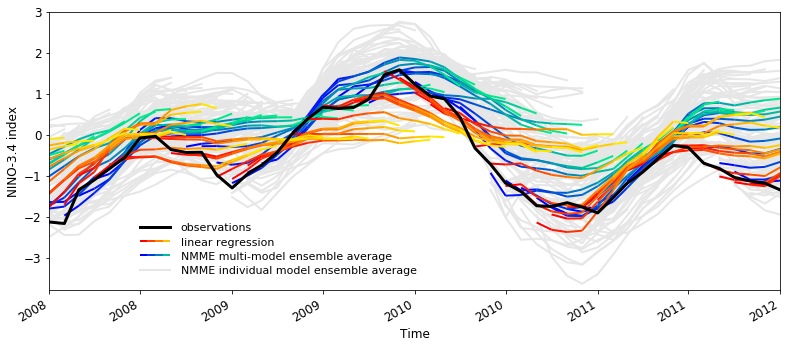

In [219]:
fcst_dates = pd.date_range(start='2006-01', end='2013-01', freq='MS')[::-1]
    
rc_params = {'figure.figsize'      : (11.1, 5.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    grey = [0.9,0.9,0.9]
    
    # Plot multi-model means -----
    for idx, date in enumerate(fcst_dates):
        to_plot = doppyo.utils.leadtime_to_datetime(mmm_nino34[anomaly_gp].sel(init_date=date))
        if idx == 0:
            plot_fcst(to_plot.time, to_plot, cmap='winter', 
                      **{'label':'NMME multi-model ensemble average'})
        else:
            plot_fcst(to_plot.time, to_plot, cmap='winter', 
                      **{'label':'_nolegend_'})

    # Plot regression(s) -----
    regr = 'linear regression'
    for idx, date in enumerate(fcst_dates):
        to_plot = doppyo.utils.leadtime_to_datetime(regr_nino34[regr][anomaly_gp].sel(init_date=date))
        if idx == 0:
            plot_fcst(to_plot.time, to_plot, cmap='autumn', 
                      **{'label':regr})
        else:
            plot_fcst(to_plot.time, to_plot, cmap='autumn', 
                      **{'label':'_nolegend_'})

    # Plot individual forecast members -----
    for idx, date in enumerate(fcst_dates):
        for idy, fcst in enumerate(fcst_nino34.values()):
            to_plot = doppyo.utils.leadtime_to_datetime(fcst[anomaly_gp].sel(init_date=date))
            if (idx == 0) & (idy == 0):
                plt.plot(to_plot.time.values, to_plot.mean('ensemble'),
                         color=grey, zorder=1, label='NMME individual model ensemble average')
            else:
                plt.plot(to_plot.time.values, to_plot.mean('ensemble'), 
                         color=grey, zorder=1, label='_nolegend_')

    obs_nino34[anomaly_gp].sel(lead_time=0).plot(color='k', linestyle='-', linewidth=3, label='Observations')

    plt.xlim(np.datetime64('2008'),
             np.datetime64('2012'))
    plt.ylim(-3.8,3);
    plt.xlabel('Time');
    plt.ylabel('NINO-3.4 index');
    plt.title('')

    # Manually make the legend -----
    span = pd.date_range('2008-07-01','2008-09-01', freq='15D')
    plt.plot(span, -3.3*np.ones_like(span.astype(int)), color=grey, zorder=1)
    plt.text(np.datetime64('2008-09-20'), -3.4, 'NMME individual model ensemble average', fontsize=11)
    plot_fcst(span, -2.95*np.ones_like(span.astype(int)), cmap='winter')
    plt.text(np.datetime64('2008-09-20'), -3.05, 'NMME multi-model ensemble average', fontsize=11)
    plot_fcst(span, -2.6*np.ones_like(span.astype(int)), cmap='autumn')
    plt.text(np.datetime64('2008-09-20'), -2.7, regr, fontsize=11)
    plt.plot(span, -2.25*np.ones_like(span.astype(int)), color='k', linestyle='-', linewidth=3)
    plt.text(np.datetime64('2008-09-20'), -2.35, 'observations', fontsize=11)

    plt.tight_layout();
    # plt.savefig(saveloc + 'nino34_timeseries.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_timeseries.pdf', format='pdf', bbox_inches='tight')

# Let's get an appreciation of the absolute NMME skill by looking at the Gerrity (categorical) skill score and the mean squared skill score (MSSS)

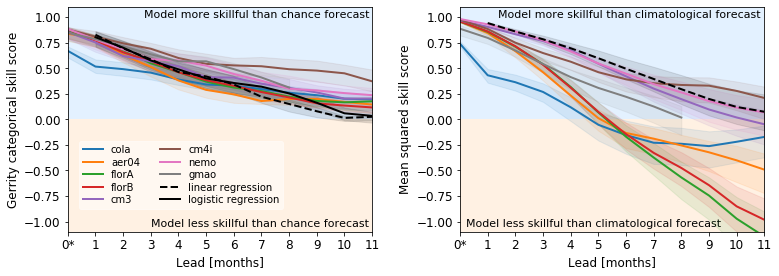

In [225]:
test_period = slice('1999','2015')

n_bootstraps = 1000
n_random_ensembles = len(fcst_nino34[list(fcst_nino34.keys())[0]].ensemble)
n_random_init_dates = len(fcst_nino34[list(fcst_nino34.keys())[0]].sel(init_date=test_period).init_date)
quantiles = [0.05, 0.95]

rc_params = {'figure.figsize'      : (11.1, 4.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25,
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    axes = fig.subplots(nrows=1, ncols=2)

    # Pierce's score =============================================================
    ref = obs_where_event
    edges = [-np.inf, -0.5, 0.5, np.inf]

    col_n = 0
    for model_name, model in {**fcst_nino34, **regr_nino34}.items():
        ax0 = axes[0]     
        obs = ref[anomaly_gp].sel(init_date=test_period)
        fcst = model[anomaly_gp].sel(init_date=test_period)
        
        if model_name == 'linear regression':
            Gerrity_bootstrapped = bootstrap_skill_metric(
                    fcst,
                    obs,
                    get_Gerrity_score,
                    k=n_bootstraps,
                    n=n_random_init_dates,
                    j=None, 
                    skill_metric_kwargs={'category_edges_cmp': edges, 
                                         'category_edges_ref': edges, 
                                         'over_dims': 'init_date'},
                    with_dask=True)
            Gerrity = get_Gerrity_score(fcst, obs, edges, edges, 'init_date')

            ax0.fill_between(Gerrity_bootstrapped. lead_time,
                             Gerrity_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             Gerrity_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color='k',
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax0.plot(Gerrity.lead_time, Gerrity, label='__nolegend', linewidth=3, color='w', linestyle='--', zorder=2)
            ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color='k', linestyle='--', zorder=2)
        elif model_name == 'logistic regression':
            Gerrity_bootstrapped = bootstrap_skill_metric(
                    fcst,
                    obs,
                    get_Gerrity_score,
                    k=n_bootstraps,
                    n=n_random_init_dates,
                    j=None, 
                    skill_metric_kwargs={'category_edges_cmp': edges, 
                                         'category_edges_ref': edges, 
                                         'over_dims': 'init_date'},
                    with_dask=True)
            Gerrity = get_Gerrity_score(fcst, obs, edges, edges, 'init_date')
        
            ax0.fill_between(Gerrity_bootstrapped. lead_time,
                             Gerrity_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             Gerrity_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color='k',
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax0.plot(Gerrity.lead_time, Gerrity, label='__nolegend', linewidth=3, linestyle='-', color='w', zorder=2)
            ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color='k', linestyle='-', zorder=2)
        else:
            Gerrity_bootstrapped = bootstrap_skill_metric(
                    fcst,
                    obs,
                    get_Gerrity_score,
                    k=n_bootstraps,
                    n=n_random_init_dates,
                    j=n_random_ensembles, 
                    skill_metric_kwargs={'category_edges_cmp': edges, 
                                         'category_edges_ref': edges, 
                                         'over_dims': 'init_date'},
                    with_dask=True)
            Gerrity = get_Gerrity_score(fcst.mean('ensemble'), obs, edges, edges, 'init_date')

            ax0.fill_between(Gerrity_bootstrapped. lead_time,
                             Gerrity_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             Gerrity_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color=colors[col_n],
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax0.plot(Gerrity.lead_time, Gerrity, label='__nolegend', linewidth=3, color='w', zorder=2)
            ax0.plot(Gerrity.lead_time, Gerrity, label=model_name, color=colors[col_n], zorder=2)
            col_n+=1
        
        legend = ax0.legend(ncol=2, loc='lower left', bbox_to_anchor=[0.02,0.08,1,1], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
        ax0.set_xlim(0,11)
        ax0.set_xticks(np.arange(0,12))
        ax0.set_ylim(-1.1,1.1)
        ax0.set_ylabel("Gerrity categorical skill score")
        ax0.set_xlabel('Lead [months]')

    # Shade regions ------
    ymin, ymax = ax0.get_ylim()
    xmin, xmax = ax0.get_xlim()
    ax0.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax0.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax0.text(2.75,0.99,'Model more skillful than chance forecast', fontsize=11)
    ax0.text(3.00,-1.05,'Model less skillful than chance forecast', fontsize=11)
    ax0.set_xticks(np.arange(0,12))
    ax0.set_xticklabels(['0*'] + np.arange(1,12).tolist())

    # MSSS ======================================================================
    # Climatological forecast -----
    clim_period = slice('1982','1998')
    clim = obs_nino34['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    clim_fcst = (0*obs_nino34['full']).groupby('init_date').apply(lambda_anomalize, clim=-clim)

    reference_MSE = doppyo.skill.mean_squared_error(clim_fcst, obs_nino34['full'], over_dims='init_date')

    col_n = 0
    for model_name, model in {**fcst_nino34, **regr_nino34}.items():
        ax1 = axes[1]
        
        obs = obs_nino34[anomaly_gp].sel(init_date=test_period)
        fcst = model[anomaly_gp].sel(init_date=test_period)

        if model_name == 'logistic regression':
            pass
        elif model_name == 'linear regression':
            MSSS_bootstrapped = bootstrap_skill_metric(
                fcst,
                obs,
                get_MSS_score,
                k=n_bootstraps,
                n=len(fcst.init_date),
                j=None, 
                skill_metric_kwargs={'reference_MSE': reference_MSE, 
                                     'over_dims': 'init_date'},
                with_dask=True)
            MSSS = get_MSS_score(fcst, obs, reference_MSE, 'init_date')
            
            ax1.fill_between(MSSS_bootstrapped. lead_time,
                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color='k',
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax1.plot(MSSS.lead_time, MSSS, label='__nolegend', linewidth=3, color='w', linestyle='--', zorder=2)
            ax1.plot(MSSS.lead_time, MSSS, label=model_name, color='k', linestyle='--', zorder=2)
        else:
            MSSS_bootstrapped = bootstrap_skill_metric(
                fcst,
                obs,
                get_MSS_score,
                k=n_bootstraps,
                n=len(fcst.init_date),
                j=n_random_ensembles, 
                skill_metric_kwargs={'reference_MSE': reference_MSE, 
                                     'over_dims': 'init_date'},
                with_dask=True)
            MSSS = get_MSS_score(fcst.mean('ensemble'), obs, reference_MSE, 'init_date')
            
            ax1.fill_between(MSSS_bootstrapped. lead_time,
                             MSSS_bootstrapped.quantile(q=quantiles[0], dim='k'),
                             MSSS_bootstrapped.quantile(q=quantiles[1], dim='k'),
                             color=colors[col_n],
                             alpha=0.1, label='__nolegend', zorder=1)
            #ax1.plot(MSSS.lead_time, MSSS, label='__nolegend', linewidth=3, color='w', zorder=2)
            ax1.plot(MSSS.lead_time, MSSS, label=model_name, color=colors[col_n], zorder=2)
            col_n+=1

    ax1.set_xlim(0,11)
    ax1.set_xticks(np.arange(0,12))
    ax1.set_ylim(-1.1,1.1)
    ax1.set_ylabel('Mean squared skill score')
    ax1.set_xlabel('Lead [months]')
    ax1.set_xticks(np.arange(0,12))
    ax1.set_xticklabels(['0*'] + np.arange(1,12).tolist())

    # Shade regions ------
    ymin, ymax = ax1.get_ylim()
    xmin, xmax = ax1.get_xlim()
    ax1.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax1.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax1.text(1.37,0.99,'Model more skillful than climatological forecast', fontsize=11, zorder=0)
    ax1.text(0.2,-1.05,'Model less skillful than climatological forecast', fontsize=11, zorder=0)

    fig.tight_layout()
    #plt.savefig(saveloc + 'nino34_Gerrity_and_MSSS.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_Gerrity_and_MSSS.pdf', format='pdf', bbox_inches='tight')

# Can we make a schematic showing the different types of anomaly calculation?

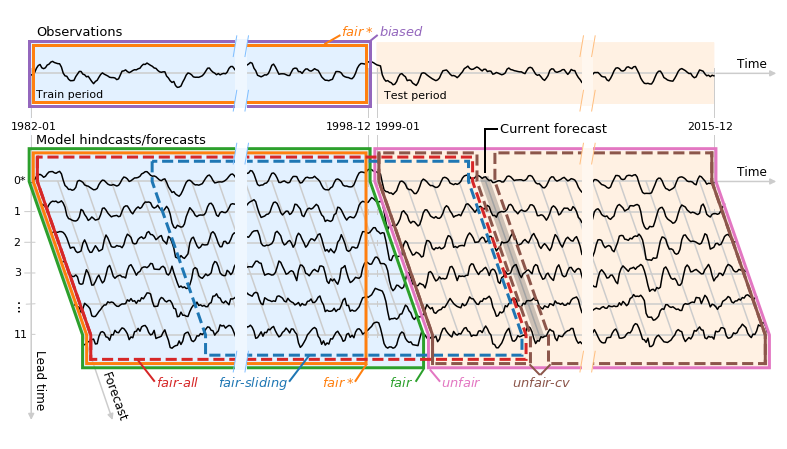

In [226]:
rc_params = {'figure.figsize'      : (13.8, 8),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    grey = [0.8,0.8,0.8]
    border_linewidth = 3
    linewidth = 2
    fontsize = 12
    
    leads = [0,1,2,3,6,11]
    shift = 6
    clip_ends = 4

    period = slice('1982-01','2015-12')
    obs = obs_nino34['full'].sel(init_date=period, lead_time=0).rename({'init_date':'time'})
    hcst = cm4_nino34['full'].sel(init_date=period).mean('ensemble').compute()

    obs_plot = obs[:-len(leads)*clip_ends]+2.5*shift
    time_plot = obs_plot.time
    min_time = time_plot.min().values
    max_time = time_plot.max().values
    plt.plot(time_plot,obs_plot,color='k', linewidth=linewidth-0.5)
    plt.plot([min_time, max_time],[obs_plot.mean('time'), obs_plot.mean('time')], color=grey, zorder=0, linewidth=linewidth-0.5)
    ax.annotate("", xy=(mdates.date2num(max_time)+1100, obs_plot.mean('time')), xycoords='data',
                            xytext=(mdates.date2num(max_time), obs_plot.mean('time')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
    plt.text(doppyo.sugar.month_delta(max_time, 13), obs_plot.mean('time')+1.1, 'Time', fontsize=fontsize)

    # Patch vertices -----
    hcst_span = 189
    gap = 5
    v1_s = [[mdates.date2num(min_time), obs_plot.mean('time').values+shift]]
    v1_e = [[mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span)), obs_plot.mean('time').values+shift]]
    v2_s = [[mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span+gap)), obs_plot.mean('time').values+shift]]
    v2_e = [[mdates.date2num(max_time), obs_plot.mean('time').values+shift]]

    # Anomaly boxes -----
    adj_x = 35 #22
    adj_y = 0.41 #0.25
    c0 = [[mdates.date2num(min_time)-adj_x, obs_plot.mean('time').values-shift-adj_y], 
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))+adj_x, obs_plot.mean('time').values-shift-adj_y],
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))+adj_x, obs_plot.mean('time').values+shift+adj_y], 
          [mdates.date2num(min_time)-adj_x, obs_plot.mean('time').values+shift+adj_y]]
    c3a = [[mdates.date2num(min_time)+adj_x, obs_plot.mean('time').values-shift+adj_y], 
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))-adj_x, obs_plot.mean('time').values-shift+adj_y],
          [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))-adj_x, obs_plot.mean('time').values+shift-adj_y], 
          [mdates.date2num(min_time)+adj_x, obs_plot.mean('time').values+shift-adj_y]]

    for idx, lead in enumerate(leads):
        if idx == 0:
            hcst_plot = (hcst.sel(lead_time=lead)-(idx+1)*shift)[idx*clip_ends:-(len(leads)-idx)*clip_ends]
            first_mean = hcst_plot.mean('init_date')
        else:
            hcst_plot = hcst.sel(lead_time=lead)[idx*clip_ends:-(len(leads)-idx)*clip_ends]
            hcst_plot = hcst_plot - hcst_plot.mean('init_date') + first_mean - idx*shift

        time_plot = [doppyo.sugar.month_delta(date, idx*2) for date in hcst_plot.init_date.values]

        plt.plot(time_plot, hcst_plot, color='k', linewidth=linewidth-0.5)
        plt.plot([min(time_plot), max(time_plot)],[hcst_plot.mean('init_date'), hcst_plot.mean('init_date')], color=grey, zorder=0, linewidth=linewidth-0.5)
        if idx == 0:
            ax.annotate("", xy=(mdates.date2num(max(time_plot))+1100, hcst_plot.mean('init_date')), xycoords='data',
                            xytext=(mdates.date2num(max(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
            plt.text(doppyo.sugar.month_delta(max(time_plot),13), hcst_plot.mean('init_date')+1.1, 'Time', fontsize=fontsize)
            ax.annotate("", xy=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')-47), xycoords='data',
                            xytext=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
            plt.text(doppyo.sugar.month_delta(min(time_plot),1), hcst_plot.mean('init_date')-len(leads)*shift-8, 'Lead time', rotation=-90, fontsize=fontsize)
            ax.annotate("", xy=(mdates.date2num(min(time_plot))+1400, hcst_plot.mean('init_date')-47), xycoords='data',
                            xytext=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                            arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
            plt.text(doppyo.sugar.month_delta(min(time_plot),38), hcst_plot.mean('init_date')-len(leads)*shift-10.7, 'Forecast', rotation=-70, fontsize=fontsize)

            # Make grid -----
            step = 15
            count=0
            for s in np.arange(step, 390, step):
                plt.plot([mdates.date2num(doppyo.sugar.month_delta(min_time,s)),mdates.date2num(doppyo.sugar.month_delta(min_time,s+30))],
                         [hcst_plot.mean('init_date').values, hcst_plot.mean('init_date').values-(len(leads)-1)*shift], color=grey, zorder=1, linewidth=linewidth-0.5)
                if count == 16:
                    plt.plot([mdates.date2num(doppyo.sugar.month_delta(min_time,s)),mdates.date2num(doppyo.sugar.month_delta(min_time,s+30))],
                         [hcst_plot.mean('init_date').values, hcst_plot.mean('init_date').values-(len(leads)-1)*shift], color='k', zorder=2, linewidth=linewidth+7, linestyle='-', alpha=0.2)
                count+=1
            v1_s.append([mdates.date2num(min(time_plot)), hcst_plot.mean('init_date').values+shift])
            v1_e.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span)), hcst_plot.mean('init_date').values+shift])
            v2_s.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span+gap)), hcst_plot.mean('init_date').values+shift])
            v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values+shift])

        # Patch vertices -----
        v1_s.append([mdates.date2num(min(time_plot)), hcst_plot.mean('init_date').values])
        v1_e.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span)), hcst_plot.mean('init_date').values])
        v2_s.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span+gap)), hcst_plot.mean('init_date').values])
        v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values])
        if idx == len(leads)-1:
            time_extra = min(time_plot) #doppyo.sugar.month_delta(min(time_plot),lead+(leads[1]-leads[0]))
            v1_s.append([mdates.date2num(time_extra), hcst_plot.mean('init_date').values-shift])
            v1_e.append([mdates.date2num(doppyo.sugar.month_delta(time_extra,hcst_span)), hcst_plot.mean('init_date').values-shift])
            v2_s.append([mdates.date2num(doppyo.sugar.month_delta(time_extra,hcst_span+gap)), hcst_plot.mean('init_date').values-shift])
            v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values-shift])

    v1 = v1_s + v1_e[::-1]
    v2 = v2_s + v2_e[::-1]
    pgon1 = plt.Polygon(v1, color=upper_color, zorder=0)
    pgon2 = plt.Polygon(v2, color=lower_color, zorder=0)
    ax.add_patch(pgon1)
    ax.add_patch(pgon2)

    vw = [[mdates.date2num(min_time)-1,27],[mdates.date2num(max_time)+1,27],
          [mdates.date2num(max_time)+1,36],[mdates.date2num(min_time)-1,36]]
    pgonw = plt.Polygon(vw, color='w', zorder=0)
    ax.add_patch(pgonw)

    # Anomaly boxes -----
    pgonc0 = plt.Polygon(c0, edgecolor=colors[4], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc0)
    c1 = [[v[0]+0*adj_x, v[1]] for v in v2_s[1:]] + v2_e[1:][::-1]
    v_tmp = v2_e[1:][::-1]
    c1 = [[v[0]-1*adj_x, v[1]] for v in [[v2_s[1][0], v2_s[1][1]+1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]-1*adj_y]]] + \
            [[v[0]+1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]]
    pgonc1 = plt.Polygon(c1, edgecolor=colors[6], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc1)
    v_tmp = v1_e[1:][::-1]
    c2 = [[v[0]-1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]+1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]-1*adj_y]]] + \
            [[v[0]+1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]]
    pgonc2 = plt.Polygon(c2, edgecolor=colors[2], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc2)
    pgonc3a = plt.Polygon(c3a, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc3a)
    v_tmp = v1_e[1:3] + [[v1_e[1][0],v1_e[-1][1]]]
    c3b = [[v[0]+1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+1*adj_y]]] + \
            [[v[0]-1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]][::-1]
    pgonc3b = plt.Polygon(c3b, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10)
    ax.add_patch(pgonc3b)

    v_tmp = v1_e[1:][::-1]
    slide = 1890
    cs = [[v[0]+5*adj_x+slide, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-5*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+5*adj_y]]] + \
            [[v[0]-5*adj_x+slide, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+5*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-5*adj_y]]]
    pgoncs = plt.Polygon(cs, edgecolor=colors[0], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    ax.add_patch(pgoncs)

    ca = [[v[0]+3*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-3*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+3*adj_y]]] + \
            [[v[0]-3*adj_x+slide, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+3*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-3*adj_y]]]
    pgonca = plt.Polygon(ca, edgecolor=colors[3], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    ax.add_patch(pgonca)
    c_solid = ca[0:8]
    plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[3], linewidth=border_linewidth, zorder=11)


    v_tmp = v2_e[1:][::-1]
    c1cva = [[v[0]+1*adj_x, v[1]] for v in [[v2_s[1][0], v2_s[1][1]-1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]+1*adj_y]]] + \
            [[v[0]-1*adj_x-(5900-slide), v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-1*adj_y]]]
    pgonc1cva = plt.Polygon(c1cva, edgecolor=colors[5], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    c_solid = c1cva[0:8]
    plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[5], linewidth=border_linewidth, zorder=11)
    ax.add_patch(pgonc1cva)
    c1cvb = [[v[0]+1*adj_x+1980, v[1]] for v in [[v2_s[1][0], v2_s[1][1]-1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]+1*adj_y]]] + \
            [[v[0]-1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-1*adj_y]]]
    pgonc1cvb = plt.Polygon(c1cvb, edgecolor=colors[5], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
    ax.add_patch(pgonc1cvb)
    c_solid = c1cvb[-8:]
    plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[5], linewidth=border_linewidth, zorder=11)

    ax.set_ylim(-30,55)
    ax.set_xlim(np.datetime64('1981'),np.datetime64('2017'))
    ax.text(mdates.date2num(min_time)+80, 49.3, 'Observations',fontsize=fontsize+1)
    ax.text(mdates.date2num(min_time)+80, 28.4, 'Model hindcasts/forecasts',fontsize=fontsize+1)
    ax.text(doppyo.sugar.month_delta(min_time,hcst_span-186), 37.3, 'Train period',fontsize=fontsize-1)
    ax.text(doppyo.sugar.month_delta(max_time,-185), 37.1, 'Test period',fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+8000, 30.4, 'Current forecast',fontsize=fontsize+1, zorder=11)
    plt.plot((mdates.date2num(min_time)+7750, mdates.date2num(min_time)+7750), (22.8,31.2), color='k', linewidth=linewidth, zorder=11,linestyle='-')
    plt.plot((mdates.date2num(min_time)+7750, mdates.date2num(min_time)+7950), (31.2,31.2), color='k', linewidth=linewidth, zorder=11,linestyle='-')

    # Add breaks -----
    start = mdates.date2num(min_time)+3480
    width = 200
    height = 2.7
    offset = 0.5
    slant = 30
    col = ((9*upper_color - 8) + 1) / 2
    col_fill = ((9*upper_color - 8) + 15) / 16
    vb1 = [[start,-15.9],[start+width,-15.9],
          [start+width,48.8],[start,48.8]]
    pgonb1 = plt.Polygon(vb1, zorder=10, hatch=None, facecolor=col_fill, edgecolor=col_fill, linewidth=0)
    ax.add_patch(pgonb1)
    vw1 = [[start,27.5],[start+width,27.5],
          [start+width,35.3],[start,35.3]]
    pgonw1 = plt.Polygon(vw1, zorder=10, hatch=None, facecolor='w', edgecolor='w', linewidth=0)
    ax.add_patch(pgonw1)
    plt.plot([start-slant, start+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)

    start = mdates.date2num(min_time)+9400
    col = ((9*lower_color - 8) + 1) / 2
    col_fill = ((9*lower_color - 8) + 15) / 16
    vb2 = [[start,-15.9],[start+width,-15.9],
          [start+width,48.5],[start,48.5]]
    pgonb2 = plt.Polygon(vb2, zorder=10, hatch=None, facecolor=col_fill, edgecolor=col_fill, linewidth=0)
    ax.add_patch(pgonb2)
    vw2 = [[start,27.5],[start+width,27.5],
          [start+width,35.6],[start,35.6]]
    pgonw2 = plt.Polygon(vw2, zorder=10, hatch=None, facecolor='w', edgecolor='w', linewidth=0)
    ax.add_patch(pgonw2)
    plt.plot([start-slant, start+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start-slant, start+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)
    plt.plot([start+width-slant, start+width+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)

    # Add dates -----
    yloc = 31
    ax.text(mdates.date2num(min_time)-350, yloc, '1982-01', fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+5030, yloc, '1998-12', fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+5870, yloc, '1999-01', fontsize=fontsize-1)
    ax.text(mdates.date2num(min_time)+11200, yloc, '2015-12', fontsize=fontsize-1)

    # Add lead time ticks -----
    straighten = 0.6
    base = 21
    ticks = ['0*','1','2','3','...','11']
    for idx, tick in enumerate(ticks):
        if tick == '...':
            ax.annotate(tick, xy=(mdates.date2num(min_time)+100, base-idx*shift), xycoords='data', rotation=90,fontsize=fontsize+3,
                        xytext=(mdates.date2num(min_time)-410, base-idx*shift-1.7*straighten), textcoords='data',
                        arrowprops=dict(arrowstyle="-", color=grey, linewidth=linewidth-1))
        else:        
            ax.annotate(tick, xy=(mdates.date2num(min_time)+100, base-idx*shift), xycoords='data',fontsize=fontsize-1,
                        xytext=(mdates.date2num(min_time)-300, base-idx*shift-straighten), textcoords='data',
                        arrowprops=dict(arrowstyle="-", color=grey, linewidth=linewidth-1))

    # Legend -----
    plt.plot((doppyo.sugar.month_delta(min_time,166+24), doppyo.sugar.month_delta(min_time,170+24)),
             (48.3,49.4), color=colors[4], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,170+25), 49.4, '$biased$', fontsize=fontsize+1, color=colors[4])

    plt.plot((doppyo.sugar.month_delta(min_time,240-16), doppyo.sugar.month_delta(min_time,245-16)),
             (-16.0,-18.1), color=colors[6], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,246-16), -19.3, '$unfair$', fontsize=fontsize+1, color=colors[6])

    plt.plot((doppyo.sugar.month_delta(min_time,240+40), doppyo.sugar.month_delta(min_time,245+40)),
             (-15.0,-16.8), color=colors[5], linewidth=linewidth, zorder=20)
    plt.plot((doppyo.sugar.month_delta(min_time,245+46), doppyo.sugar.month_delta(min_time,240+46)),
             (-15.0,-16.8), color=colors[5], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,246+24), -19.3, '$unfair$-$cv$', fontsize=fontsize+1, color=colors[5])

    plt.plot((doppyo.sugar.month_delta(min_time,235-15), doppyo.sugar.month_delta(min_time,231-15)),
             (-15.9,-18.1), color=colors[2], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,221-20), -19.3, '$fair$', fontsize=fontsize+1, color=colors[2])

    plt.plot((doppyo.sugar.month_delta(min_time,164+24), doppyo.sugar.month_delta(min_time,169+13)),
             (-14.9,-18.1), color=colors[1], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,169-6), -19.3, '$fair*$', fontsize=fontsize+1, color=colors[1])
    plt.plot((doppyo.sugar.month_delta(min_time,147+18), doppyo.sugar.month_delta(min_time,155+18)),
             (47.8,49.4), color=colors[1], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,155+19), 49.4, '$fair*$', fontsize=fontsize+1, color=colors[1])

    plt.plot((doppyo.sugar.month_delta(min_time,164-8), doppyo.sugar.month_delta(min_time,164-19)),
             (-13.1,-18.1), color=colors[0], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,165-60), -19.3, '$fair$-$sliding$', fontsize=fontsize+1, color=colors[0])

    plt.plot((doppyo.sugar.month_delta(min_time,104-44), doppyo.sugar.month_delta(min_time,104-35)),
             (-14.1,-18.1), color=colors[3], linewidth=linewidth, zorder=20)
    ax.text(doppyo.sugar.month_delta(min_time,165-95), -19.3, '$fair$-$all$', fontsize=fontsize+1, color=colors[3])

    # plt.plot((doppyo.sugar.month_delta(min_time,90), doppyo.sugar.month_delta(min_time,90)),
    #          (33.5,35.5), color=colors[0], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,85), 31, 'C0', fontsize=fontsize+2, color=colors[0])
    # plt.plot((doppyo.sugar.month_delta(min_time,110), doppyo.sugar.month_delta(min_time,110)),
    #          (33.5,36.4), color=colors[3], linewidth=linewidth, zorder=20)
    # plt.plot((doppyo.sugar.month_delta(min_time,110), doppyo.sugar.month_delta(min_time,110)),
    #          (27,30), color=colors[3], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,105), 31, 'C3', fontsize=fontsize+2, color=colors[3])
    # plt.plot((doppyo.sugar.month_delta(min_time,130), doppyo.sugar.month_delta(min_time,130)),
    #          (27.5,30), color=colors[2], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,125), 31, 'C2', fontsize=fontsize+2, color=colors[2])
    # plt.plot((doppyo.sugar.month_delta(min_time,205), doppyo.sugar.month_delta(min_time,205)),
    #          (27.3,30), color=colors[1], linewidth=linewidth, zorder=20)
    # ax.text(doppyo.sugar.month_delta(min_time,200), 31, 'C1', fontsize=fontsize+2, color=colors[1])

    plt.plot((min_time, min_time), (20,30), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((min_time, min_time), (33.5,43), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    # for tick in np.arange(len(leads)):
    #     plt.plot((min_time, min_time), (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), (20,30), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), (33.5,43), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    for tick in np.arange(len(leads)):
        plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), 
                 (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), (20,30), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), (33.5,43), 
             color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    for tick in np.arange(len(leads)):
        plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), 
                 (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((max_time, max_time), (20,30), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    plt.plot((max_time, max_time), (33.5,43), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
    for tick in np.arange(len(leads)):
        plt.plot((max_time, max_time), (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')

    ax.axis('off');
    #plt.savefig(saveloc + 'anomaly_schematic.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'anomaly_schematic.pdf', format='pdf', bbox_inches='tight')

# Can we see a step change in the error around 1999

In [227]:
er_nino34 = {fcst_name: (fcst.mean('ensemble') - obs_nino34) for fcst_name, fcst in fcst_nino34.items()}

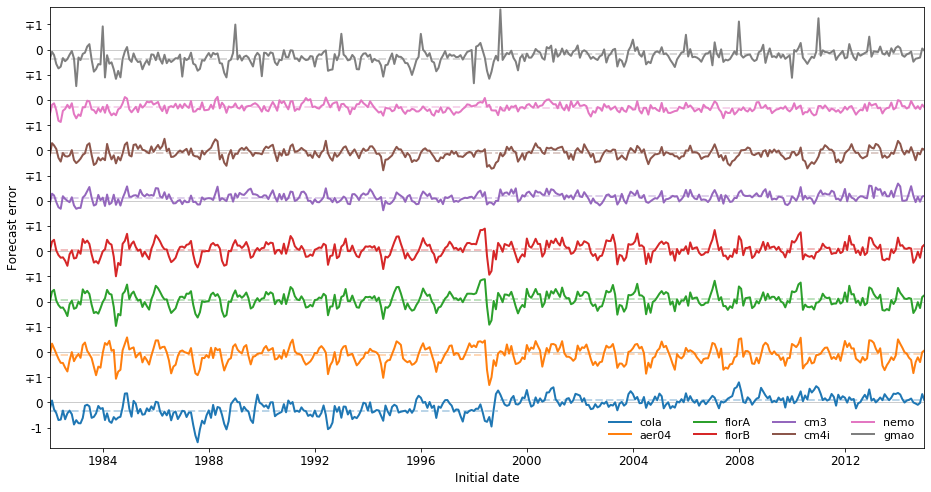

In [228]:
lead = 0
anom = 'full'

rc_params = {'figure.figsize'      : (13.1, 7),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    
    fig = plt.figure()
    
    col_n = 0
    for er_name, er in er_nino34.items(): 
        to_plot = er[anom].sel(lead_time=lead)
        plt.plot([np.datetime64('1960'),np.datetime64('2018')],[2*col_n, 2*col_n], color=grey, linewidth=1)
        plt.plot(to_plot.init_date, to_plot+col_n*2, color=colors[col_n], label=er_name)
        
        pre = to_plot.sel(init_date=slice('1982','1998'))
        plt.plot([pre.init_date.values[0], pre.init_date.values[-1]], 
                 [pre.mean('init_date')+col_n*2, pre.mean('init_date')+col_n*2], 
                 color=colors[col_n], linestyle='--', alpha=0.3, label='_nolegend_')
        post = to_plot.sel(init_date=slice('1999','2015'))
        plt.plot([post.init_date.values[0], post.init_date.values[-1]], 
                 [post.mean('init_date')+col_n*2, post.mean('init_date')+col_n*2], 
                 color=colors[col_n], linestyle='--', alpha=0.3, label='_nolegend_')
        col_n += 1
    
    plt.yticks(np.arange(-2,2*col_n,1), [-2,-1,0] + ['$\mp$1',0]*len(er_nino34))
    plt.xlim(np.datetime64('1982'),
             np.datetime64('2015'))
    plt.ylim(-1.8,1.2+2*(col_n-1)+0.5)
    plt.xlabel('Initial date')
    plt.ylabel('Forecast error')
    
    legend = plt.legend(ncol=4, fontsize=11, loc='lower right', bbox_to_anchor=[0.02,-0.005,0.98,0.5], framealpha=0.5)
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    
    fig.tight_layout()
    # plt.savefig(saveloc + 'nino34_full_error_timeseries.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_full_error_timeseries.pdf', format='pdf', bbox_inches='tight')

# What is the (sign test) skill relative to linear regression for each of the different anomaly types?

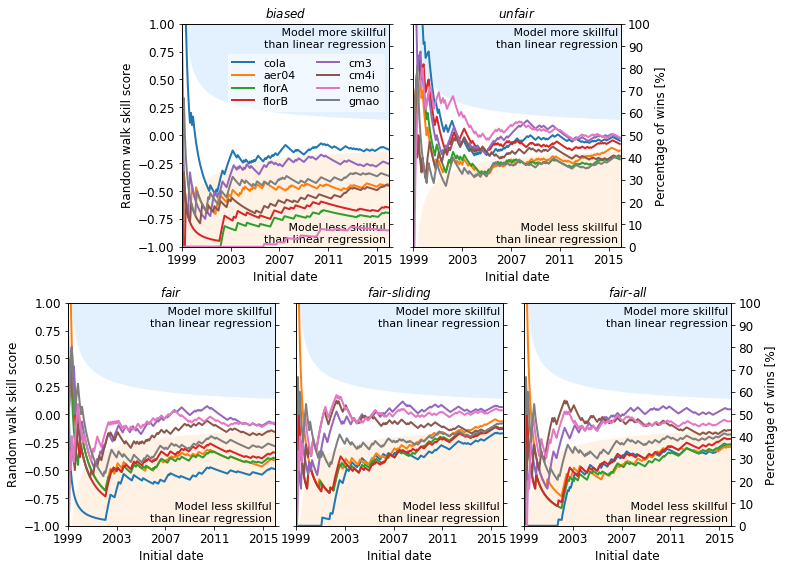

In [229]:
rc_params = {'figure.figsize'      : (9.6, 3.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    grey = 'w' #[0.9,0.9,0.9]

    fig = plt.figure()
    axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.25,0.3,1],[0.33,-1.25,0.3,1],[0.66,-1.25,0.3,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    lead = 3
    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    base = regr_nino34['linear regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        for model_name, model in fcst_nino34.items():
            sign, conf = doppyo.skill.sign_test(base[anom].sel(init_date=slice('1999','2015')), 
                                                model[anom].mean('ensemble').sel(init_date=slice('1999','2015')), 
                                                obs_nino34[anom].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])

            col_n += 1

        if idx == 0:
            legend = ax.legend(ncol=2, fontsize=11, loc='upper right', bbox_to_anchor=[0.02,0.00,0.98,0.89], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        ax.set_ylim(-1, 1)
        if (idx == 0) | (idx == 2):
            ax.set_ylabel('Random walk skill score')
        if (idx == 1) | (idx == 3) | (idx == 4):
            ax.set_yticklabels([])
        ax.set_xlabel('Initial date')
        ax.set_xticks([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
        ax.set_xticklabels([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
        ax.set_xlim(np.datetime64('1999'),
                    np.datetime64('2016'))
        anom_split = anom.split('-')
        ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0, 1)
        if (idx == 1) | (idx == 4):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
            ax2.set_ylabel('Percentage of wins [%]')
        if (idx == 0) | (idx == 2) | (idx == 3):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        ax.text(np.datetime64('2005-10'), 0.79, '     Model more skillful \nthan linear regression', fontsize=11, zorder=0)
        ax.text(np.datetime64('2005-10'), -0.96, '       Model less skillful \nthan linear regression', fontsize=11, zorder=0)

    # plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3.pdf', format='pdf', bbox_inches='tight')

### Plot the area under the curves as a function of lead time
Note that when computing the areas, it is important to only include points where the sign_test had the opportunity to change - ie. when supplying masks to the sign_test, the ssame amsks put also be applied before the integral is calculated

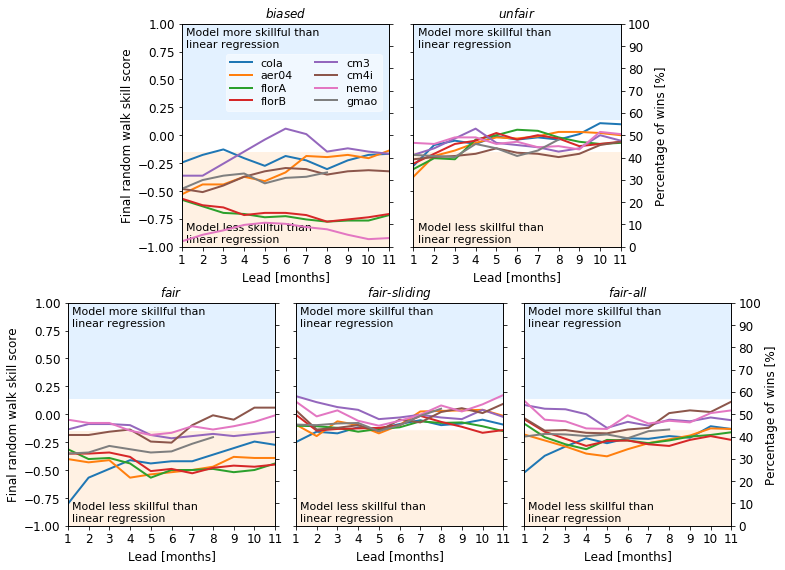

In [230]:
rc_params = {'figure.figsize'      : (9.6, 3.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.25,0.3,1],[0.33,-1.25,0.3,1],[0.66,-1.25,0.3,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    base = regr_nino34['linear regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        for model_name, model in fcst_nino34.items():
            sign, conf = doppyo.skill.sign_test(base[anom].sel(init_date=slice('1999','2015')), 
                                                model[anom].mean('ensemble').sel(init_date=slice('1999','2015')), 
                                                obs_nino34[anom].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
            ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name, color=colors[col_n], linewidth=linewidth)
            
            col_n += 1

        if idx == 0:
            legend = ax.legend(ncol=2, fontsize=11, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.89], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        # Adjust y-axes limits to be symmetric -----
        ymin, ymax = ax.get_ylim()
        ylim = max([abs(ymin), abs(ymax)])
        ax.set_ylim(-1, 1)
        ax.set_xticks(np.arange(0,12))
        ax.set_xlim(1,11)
        if (idx == 0) | (idx == 2):
            ax.set_ylabel('Final random walk skill score')
        if (idx == 1) | (idx == 3) | (idx == 4):
            ax.set_yticklabels([])
        ax.set_xlabel('Lead [months]')
        anom_split = anom.split('-')
        ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0, 1)
        if (idx == 1) | (idx == 4):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
            ax2.set_ylabel('Percentage of wins [%]')
        if (idx == 0) | (idx == 2) | (idx == 3):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        ax.text(1.2,0.79,'Model more skillful than \nlinear regression', fontsize=11, zorder=0)
        ax.text(1.2,-0.96,'Model less skillful than \nlinear regression', fontsize=11, zorder=0)

    # plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_integral.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_integral.pdf', format='pdf', bbox_inches='tight')

# What is the (sign test) skill relative to logistic regression for each of the different anomaly types?
Note in previous versions of the notebook, there was a minor error in the way the observation fair-sliding and fair-all anomalies were constructed resulting in missing data at the first and last initial dates. This has been corrected

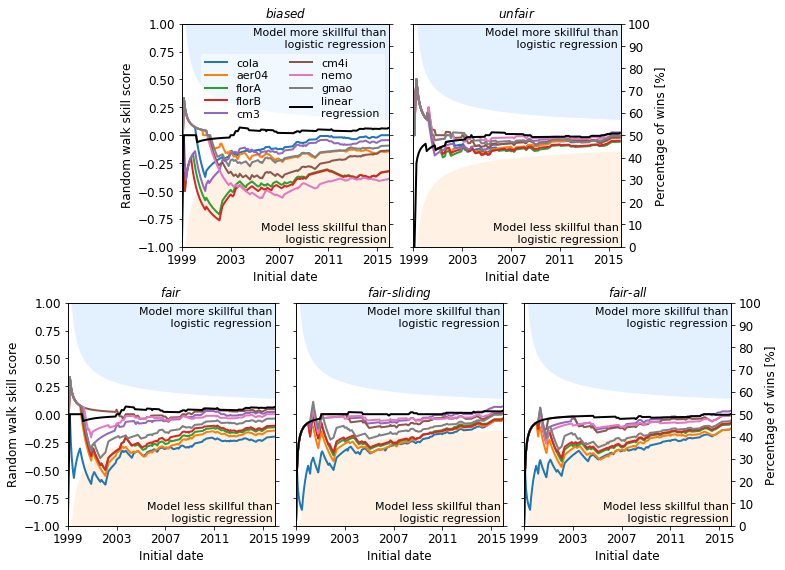

In [231]:
rc_params = {'figure.figsize'      : (9.6, 3.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    grey = 'w' #[0.9,0.9,0.9]

    fig = plt.figure()
    axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.25,0.3,1],[0.33,-1.25,0.3,1],[0.66,-1.25,0.3,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    lead = 3
    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    base = regr_where_event['logistic regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        for model_name, model in {**fcst_where_event, 
                                  **{'linear regression':regr_where_event['linear regression']}}.items():
            sign, conf = doppyo.skill.sign_test(base[anom].sel(init_date=slice('1999','2015')), 
                                                model[anom].sel(init_date=slice('1999','2015')), 
                                                obs_where_event[anom].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
            if model_name == 'linear regression':
                ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label='linear \nregression', color='k')
            else:
                ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                col_n += 1

        if idx == 0:
            legend = ax.legend(ncol=2, fontsize=11, loc='upper right', bbox_to_anchor=[0.02,0.00,0.98,0.89], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        ax.set_ylim(-1, 1)
        if (idx == 0) | (idx == 2):
            ax.set_ylabel('Random walk skill score')
        if (idx == 1) | (idx == 3) | (idx == 4):
            ax.set_yticklabels([])
        ax.set_xlabel('Initial date')
        ax.set_xticks([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
        ax.set_xticklabels([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
        ax.set_xlim(np.datetime64('1999'),
                    np.datetime64('2016'))
        anom_split = anom.split('-')
        ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0, 1)
        if (idx == 1) | (idx == 4):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
            ax2.set_ylabel('Percentage of wins [%]')
        if (idx == 0) | (idx == 2) | (idx == 3):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        ax.text(np.datetime64('2004-11'), 0.79, 'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
        ax.text(np.datetime64('2005-07'), -0.96, 'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

    # plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_lead3.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_lead3.pdf', format='pdf', bbox_inches='tight')

### Plot the area under the curves as a function of lead time
Note that when computing the areas, it is important to only include points where the sign_test had the opportunity to change - ie. when supplying masks to the sign_test, the ssame amsks put also be applied before the integral is calculated

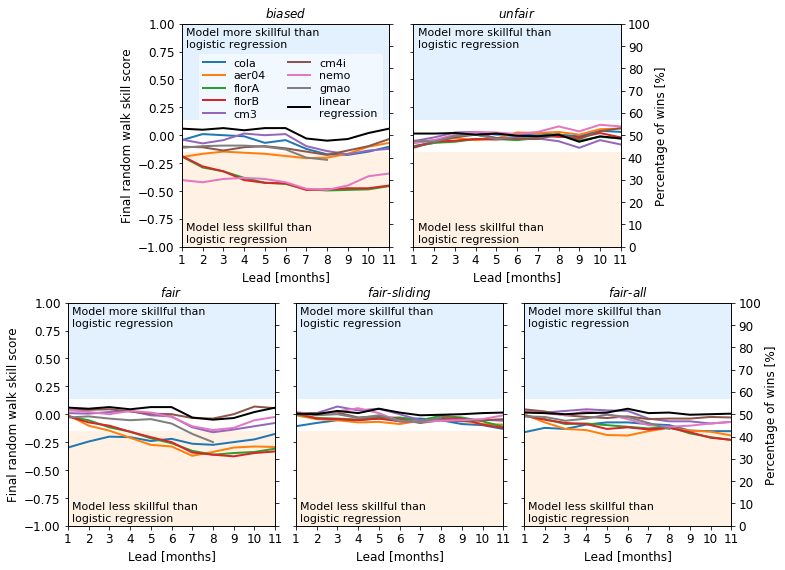

In [232]:
rc_params = {'figure.figsize'      : (9.6, 3.1),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.25,0.3,1],[0.33,-1.25,0.3,1],[0.66,-1.25,0.3,1]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    anoms = ['biased','unfair','fair', 'fair-sliding', 'fair-all']
    base = regr_nino34['logistic regression']

    for idx, anom in enumerate(anoms):
        ax = axes[idx]

        col_n = 0
        for model_name, model in {**fcst_where_event, 
                                  **{'linear regression':regr_where_event['linear regression']}}.items():
            sign, conf = doppyo.skill.sign_test(base[anom].sel(init_date=slice('1999','2015')), 
                                                model[anom].sel(init_date=slice('1999','2015')), 
                                                obs_where_event[anom].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
            if model_name == 'linear regression':
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), label='linear \nregression', color='k', linewidth=linewidth)
            else:
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name, color=colors[col_n], linewidth=linewidth)
                col_n += 1

        if idx == 0:
            legend = ax.legend(ncol=2, fontsize=11, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.89], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        # Adjust y-axes limits to be symmetric -----
        ymin, ymax = ax.get_ylim()
        ylim = max([abs(ymin), abs(ymax)])
        ax.set_ylim(-1, 1)
        ax.set_xticks(np.arange(0,12))
        ax.set_xlim(1,11)
        if (idx == 0) | (idx == 2):
            ax.set_ylabel('Final random walk skill score')
        if (idx == 1) | (idx == 3) | (idx == 4):
            ax.set_yticklabels([])
        ax.set_xlabel('Lead [months]')
        anom_split = anom.split('-')
        ax.set_title('$'+anom_split[0]+('$-$'+anom_split[1]+'$' if len(anom_split) > 1 else '$'))

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0, 1)
        if (idx == 1) | (idx == 4):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
            ax2.set_ylabel('Percentage of wins [%]')
        if (idx == 0) | (idx == 2) | (idx == 3):
            ax2.set_yticks(np.arange(0,1.1,0.1))
            ax2.set_yticklabels([])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        ax.text(1.2,0.79,'Model more skillful than \nlogistic regression', fontsize=fontsize-1)
        ax.text(1.2,-0.96,'Model less skillful than \nlogistic regression', fontsize=fontsize-1)

    # plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_integral.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_integral.pdf', format='pdf', bbox_inches='tight')

# How do the model **unfair** anomalies compare when assessed relative to observed **fair** anomalies?

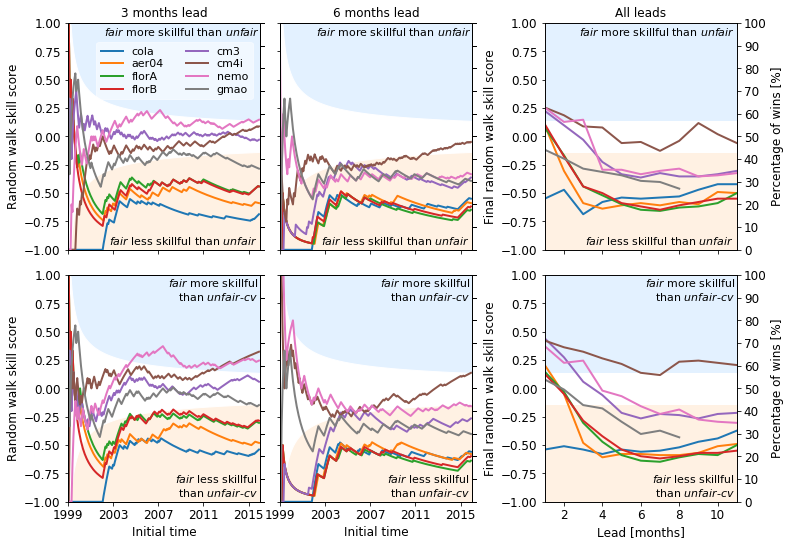

In [233]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    grey = 'w' #[0.9,0.9,0.9]

    fig = plt.figure()
    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    leads = [3, 6]
    anoms = [('unfair',anomaly_gp), ('unfair-cv:7yr',anomaly_gp)]
    # models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
    # model_name = ['cola','aer04','florA','florB','cm3','cm4']

    count=0
    for idx, anom in enumerate(anoms):
        col_n = 0
        for model_name, model in fcst_nino34.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                    model[anom[1]].mean('ensemble'), 
                                                    obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')))
                norm = (1 + 0*sign).cumsum('init_date')

                if model_name == 'cola':
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
                ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                
                ax.set_xlim(np.datetime64('1999'),
                            np.datetime64('2016'))
                ax.set_xticks([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
                ax.set_xticklabels([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
                if axI < len(anoms) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('Random walk skill score')
                if idx == 0:
                    ax.set_title(str(lead) + ' months lead', fontsize=fontsize)

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(0, 1)
                ax2.set_yticks(np.arange(0,1.1,0.1))
                ax2.set_yticklabels([])
                #ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1,1)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if (model_name == 'cola') & (idx == 0):
                    ax.text(np.datetime64('2002-03'),0.89,'$fair$ more skillful than $unfair$', fontsize=fontsize-1)
                    ax.text(np.datetime64('2002-09'),-0.96,'$fair$ less skillful than $unfair$', fontsize=fontsize-1)
                elif (model_name == 'cola') & (idx == 1):
                    ax.text(np.datetime64('2007-11'),0.77,'$fair$ more skillful \n   than $unfair$-$cv$', fontsize=fontsize-1)
                    ax.text(np.datetime64('2008-07'),-0.96,'$fair$ less skillful \n than $unfair$-$cv$', fontsize=fontsize-1)

                if (idx == 0) & (idz == 0) & (model_name == list(fcst_nino34.keys())[-1]):
                    leg = legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.94], framealpha=0.5)
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]
            sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
            ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name, color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)

            if (model_name == 'cola') & (idx == 0):
                ax.text(2.8,0.89,'$fair$ more skillful than $unfair$', fontsize=fontsize-1)
                ax.text(3.1,-0.96,'$fair$ less skillful than $unfair$', fontsize=fontsize-1)
            elif (model_name == 'cola') & (idx == 1):
                ax.text(6.2,0.77,'$fair$ more skillful \n   than $unfair$-$cv$', fontsize=fontsize-1)
                ax.text(6.6,-0.96,'$fair$ less skillful \n than $unfair$-$cv$', fontsize=fontsize-1)

            ax.set_ylim(-1,1)
            ax.set_ylabel('Final random walk skill score')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(anoms) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads', fontsize=fontsize)
                
            col_n += 1
            
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0, 1)
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1
    # plt.savefig(saveloc + 'nino34_fair-v-cheat.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_fair-v-cheat.pdf', format='pdf', bbox_inches='tight')

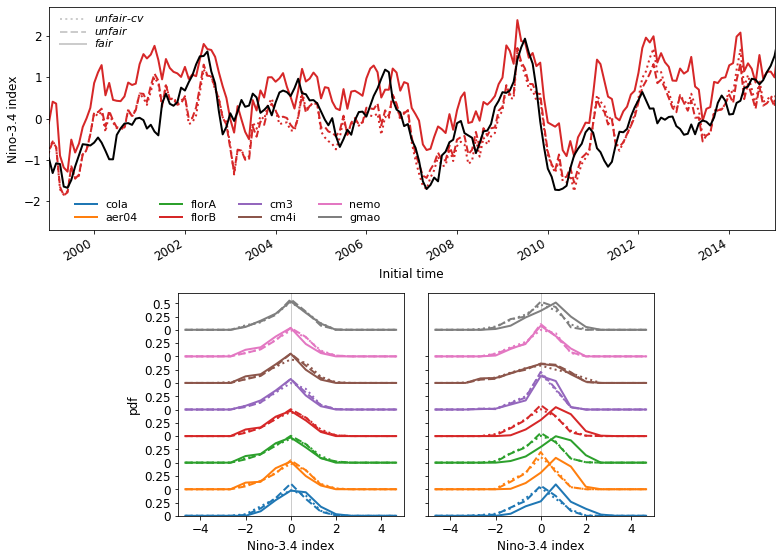

In [234]:
rc_params = {'figure.figsize'      : (11.2, 6.2),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    
    grey = [0.8,0.8,0.8]

    fig = plt.figure()
    axes_locs = [[0.1,0.64,0.9,0.5], 
                 [0.26,0,0.28,0.5],[0.57,0,0.28,0.5]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    # Timeseries plot -----
    ax = axes[0]
    lead=6
    model = florB_nino34.mean('ensemble')
    model['unfair'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle='--', label='$unfair$')
    model['unfair-cv:7yr'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle=':', label='$unfair-cv$')
    obs_nino34['unfair'].sel(lead_time=lead).plot(ax=ax, color='k', label='observations ($o_{\mathrm{test}}^{\mathrm{obs}}$)', zorder=10)
    model['fair'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle='-', label='$fair$')

    ax.set_xlim(np.datetime64('1999'),
                np.datetime64('2015'))
    ax.set_ylim(-2.7,2.7);
    ax.set_xlabel('Initial time')
    ax.set_ylabel('Nino-3.4 index')
    ax.set_title('');
    ax.set_yticks(np.arange(-2,3,1))

    # Legend -----
    span = pd.date_range('1999-04-01','1999-11-01', freq='15D')
    ax.plot(span,2.4*np.ones_like(span.astype(int)), linestyle=':', color=grey)
    ax.text(np.datetime64('2000-01'), 2.33, '$unfair$-$cv$', fontsize=11)
    ax.plot(span,2.1*np.ones_like(span.astype(int)), linestyle='--', color=grey)
    ax.text(np.datetime64('2000-01'), 2.03, '$unfair$', fontsize=11)
    ax.plot(span,1.8*np.ones_like(span.astype(int)), linestyle='-', color=grey)
    ax.text(np.datetime64('2000-01'), 1.73, '$fair$', fontsize=11);

    # pdf plots -----
    test_period = slice(np.datetime64('1999'),
                        np.datetime64('2015'))
    leads = [0, 6]
    models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
    model_name = ['cola','aer04','florA','florB','cm3','cm4']

    for idy, lead in enumerate(leads):
        ax = axes[idy+1]

        col_n = 0
        for model_name, model in fcst_nino34.items():

            pdf_mod_c1ncv = doppyo.utils.pdf((model['unfair'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*col_n
            pdf_mod_c17yr = doppyo.utils.pdf((model['unfair-cv:7yr'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*col_n
            pdf_mod_c2 = doppyo.utils.pdf((model['fair'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*col_n


            pdf_mod_c1ncv.sel(lead_time=lead).plot(ax=ax, color=colors[col_n], linestyle='--', label='_nolabel_')
            pdf_mod_c17yr.sel(lead_time=lead).plot(ax=ax, color=colors[col_n], linestyle=':', label='_nolabel_')
            pdf_mod_c2.sel(lead_time=lead).plot(ax=ax, color=colors[col_n], linestyle='-', label=model_name)

            col_n += 1
        ax.set_ylim(0,0.5*(len(models))+0.1)
        ax.set_xlabel('Nino-3.4 index')
        ax.set_title('')
        if idy == 0:
            ax.set_yticks(np.arange(0,len(fcst_nino34)/2+0.3,0.25));
            ax.set_yticklabels([0,0.25]*len(fcst_nino34)+[0.5]);
        else:
            ax.set_yticks(np.arange(0,3.25,0.25));
            ax.set_yticklabels([]);
            ax.set_ylabel('')
        ax.set_xticks(np.arange(-6,6,2))
        ax.set_xlim(-5,5)
        ax.plot([0, 0],[0, len(fcst_nino34)/2+0.2], color=grey, zorder=0, linewidth=1)
        ax.set_ylim(0,len(fcst_nino34)/2+0.2)

        if idy == 0:
            leg = legend = ax.legend(ncol=4, fontsize=11, loc='upper left', bbox_to_anchor=[-0.5,0.00,1.5,1.46], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

    # plt.savefig(saveloc + 'nino34_timeseries_pdflead0and6_CV.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_timeseries_pdflead0and6_CV.pdf', format='pdf', bbox_inches='tight')

# How do the model **fair** anomalies compare when assessed relative to observed **fair-sliding** anomalies?

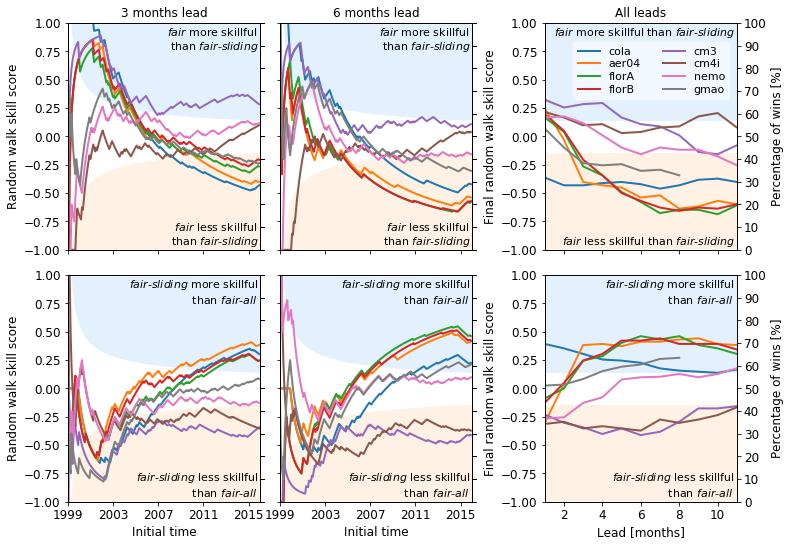

In [235]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    grey = 'w' #[0.9,0.9,0.9]

    fig = plt.figure()
    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    leads = [3, 6]
    anoms = [('fair-sliding',anomaly_gp), ('fair-all', 'fair-sliding')]

    count=0
    for idx, anom in enumerate(anoms):
        col_n = 0
        for model_name, model in fcst_nino34.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                    model[anom[1]].mean('ensemble'), 
                                                    obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')))
                norm = (1 + 0*sign).cumsum('init_date')

                if model_name == 'cola':
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
                ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name, color=colors[col_n])
                
                ax.set_xlim(np.datetime64('1999'),
                            np.datetime64('2016'))
                ax.set_xticks([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
                ax.set_xticklabels([np.datetime64(year) for year in ['1999','2003','2007','2011','2015']])
                if axI < len(anoms) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('Random walk skill score')
                if idx == 0:
                    ax.set_title(str(lead) + ' months lead', fontsize=fontsize)

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(0, 1)
                ax2.set_yticks(np.arange(0,1.1,0.1))
                ax2.set_yticklabels([])
                #ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1,1)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if (model_name == 'cola') & (idx == 0):
                    ax.text(np.datetime64('2007-10'),0.76,'$fair$ more skillful \n than $fair$-$sliding$', fontsize=fontsize-1)
                    ax.text(np.datetime64('2008-03'),-0.96,' $fair$ less skillful \nthan $fair$-$sliding$', fontsize=fontsize-1)
                elif (model_name == 'cola') & (idx == 1):
                    ax.text(np.datetime64('2004-06'),0.75,'$fair$-$sliding$ more skillful \n                  than $fair$-$all$', fontsize=fontsize-1)
                    ax.text(np.datetime64('2005-01'),-0.96,'$fair$-$sliding$ less skillful \n                than $fair$-$all$', fontsize=fontsize-1)

            ax = axes[axI+1]
            sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if model_name == 'cola':
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
            ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name, color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)

            if (model_name == 'cola') & (idx == 0):
                ax.text(1.5,0.89,'$fair$ more skillful than $fair$-$sliding$', fontsize=fontsize-1)
                ax.text(1.9,-0.96,'$fair$ less skillful than $fair$-$sliding$', fontsize=fontsize-1)
            elif (model_name == 'cola') & (idx == 1):
                ax.text(4.15,0.75,'$fair$-$sliding$ more skillful \n                  than $fair$-$all$', fontsize=fontsize-1)
                ax.text(4.5,-0.96,'$fair$-$sliding$ less skillful \n                than $fair$-$all$', fontsize=fontsize-1)

            ax.set_ylim(-1,1)
            ax.set_ylabel('Final random walk skill score')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(anoms) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads', fontsize=fontsize)
                
            if (idx == 0) & (model_name == list(fcst_nino34.keys())[-1]):
                leg = legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.94], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')
                
            col_n += 1
            
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0, 1)
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1
    # plt.savefig(saveloc + 'nino34_fair-v-fairsliding.eps', format='eps', bbox_inches='tight') 
    plt.savefig(saveloc + 'nino34_fair-v-fairsliding.pdf', format='pdf', bbox_inches='tight')

# Let's look at the model climatologies over the hindcast and verification periods

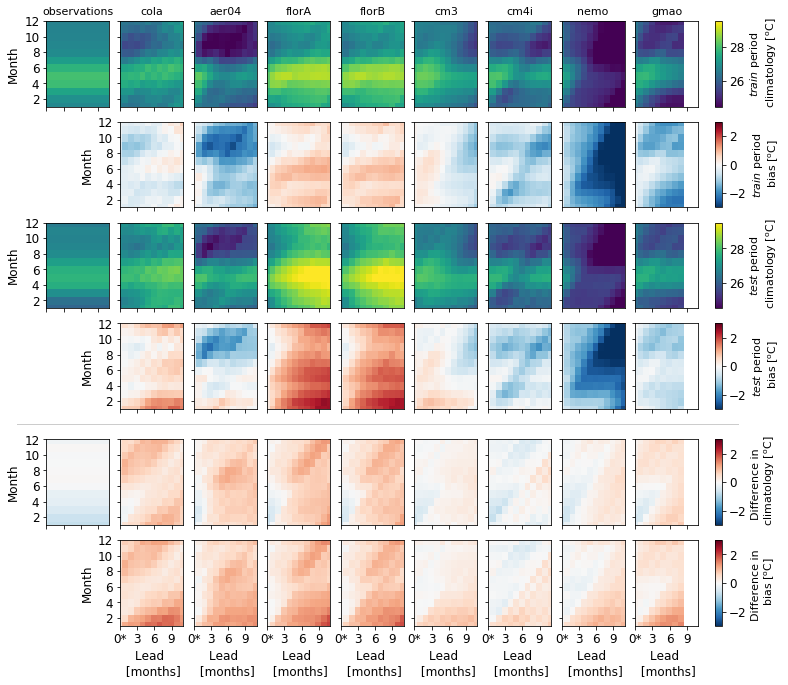

In [236]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    
    fig = plt.figure()
    grey = [0.8,0.8,0.8]
    
    models = {**{'observations': obs_nino34}, **fcst_nino34}

    width = 0.095
    height = 0.17
    axes_locs = [[x, 0.8, width, height] for x in np.arange(0, 1, 1/len(models))] + \
                [[x, 0.6, width, height] for x in np.arange(1/len(models), 1, 1/len(models))] + \
                [[x, 0.4, width, height] for x in np.arange(0, 1, 1/len(models))] + \
                [[x, 0.2, width, height] for x in np.arange(1/len(models), 1, 1/len(models))] + \
                [[x, -0.03, width, height] for x in np.arange(0, 1, 1/len(models))] + \
                [[x, -0.23, width, height] for x in np.arange(1/len(models), 1, 1/len(models))]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    train_period = slice('1982','1998')
    test_period = slice('1999','2015')

    count = 0
    for model_name, model in models.items():
        if model_name == 'observations':
            train_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=train_period)), 
                                                  init_date_coord='month')
            train_clim = train_clim.sel(lead_time=0) * (1 + 0*train_clim)
            obs_train_clim = train_clim
            test_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=test_period)), 
                                                 init_date_coord='month')
            test_clim = test_clim.sel(lead_time=0) * (1 + 0*test_clim)
            obs_test_clim = test_clim
        else:
            train_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=train_period)), 
                                                  init_date_coord='month')
            test_clim = init_date_to_target_date(monthly_climatology(model['full'].sel(init_date=test_period)), 
                                                 init_date_coord='month')

        ax0 = axes[count]
        ax1 = axes[count + len(models) - 1]
        ax2 = axes[count + 2*len(models) - 1]
        ax3 = axes[count + 3*len(models) - 2]
        ax4 = axes[count + 4*len(models) - 2]
        ax5 = axes[count + 5*len(models) - 3]

        p1 = train_clim.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=24.5, vmax=29.5, cmap='viridis') 
        if model_name != 'observations':
            p2 = (train_clim - obs_train_clim).plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
        p3 = test_clim.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=24.5, vmax=29.5, cmap='viridis') 
        if model_name != 'observations':
            p4 = (test_clim - obs_test_clim).plot(x='lead_time',ax=ax3, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
        p5 = (test_clim - train_clim).plot(x='lead_time',ax=ax4, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
        if model_name != 'observations':
            p6 = ((test_clim - obs_test_clim) - (train_clim - obs_train_clim)).plot(x='lead_time',ax=ax5, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 

        if count == (len(models)-1):
            ps = [p1, p2, p3, p4, p5, p6]
            cax_y = [0.8, 0.6,0.4,0.2,-0.03, -0.23]
            label = ['$train$ period \n climatology [$^\mathrm{o}$C]',
                    '$train$ period \n bias [$^\mathrm{o}$C]',
                    '$test$ period \n climatology [$^\mathrm{o}$C]',
                    '$test$ period \n bias [$^\mathrm{o}$C]',
                     'Difference in \n climatology [$^\mathrm{o}$C]',
                    'Difference in \n bias [$^\mathrm{o}$C]']
            for idc, p in enumerate(ps):
                cbaxes = fig.add_axes([1.01, cax_y[idc], 0.01, height]) 
                cb = plt.colorbar(p, cax = cbaxes)
                cb.set_label(label[idc], rotation=90, fontsize=11)

        if (count == 0):
            ax0.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax4.set_yticks(np.arange(0,13,2))
            ax0.set_ylabel('Month')
            ax2.set_ylabel('Month')
            ax4.set_ylabel('Month')
        else:
            ax0.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax4.set_yticks(np.arange(0,13,2))
            ax0.set_yticklabels([])
            ax2.set_yticklabels([])
            ax4.set_yticklabels([])
            ax0.set_ylabel('')
            ax2.set_ylabel('')
            ax4.set_ylabel('')

        if (count == 1):
            ax1.set_yticks(np.arange(0,13,2))
            ax3.set_yticks(np.arange(0,13,2))
            ax5.set_yticks(np.arange(0,13,2))
            ax1.set_ylabel('Month')
            ax3.set_ylabel('Month')
            ax5.set_ylabel('Month')
        else:
            ax1.set_yticks(np.arange(0,13,2))
            ax3.set_yticks(np.arange(0,13,2))
            ax5.set_yticks(np.arange(0,13,2))
            ax1.set_yticklabels([])
            ax3.set_yticklabels([])
            ax5.set_yticklabels([])
            ax1.set_ylabel('')
            ax3.set_ylabel('')
            ax5.set_ylabel('')

        ax0.set_xticks(np.arange(0,13,3))
        ax0.set_xticklabels([])
        ax0.set_xlabel('')
        ax1.set_xticks(np.arange(0,13,3))
        ax1.set_xticklabels([])
        ax1.set_xlabel('')
        ax2.set_xticks(np.arange(0,13,3))
        ax2.set_xticklabels([])
        ax2.set_xlabel('')
        ax3.set_xticks(np.arange(0,13,3))
        ax3.set_xticklabels([])
        ax3.set_xlabel('')
        ax4.set_xticks(np.arange(0,13,3))
        ax4.set_xticklabels([])
        ax4.set_xlabel('')
        ax5.set_xticks(np.arange(0,13,3))
        ax5.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
        ax5.set_xlabel('Lead \n [months]')
        ax0.set_title(model_name, fontsize=11)

        ax0.set_xlim(0,11)
        ax1.set_xlim(0,11) 
        ax2.set_xlim(0,11)
        ax3.set_xlim(0,11)
        ax4.set_xlim(0,11)
        ax5.set_xlim(0,11)
        ax0.set_ylim(1,12)
        ax1.set_ylim(1,12) 
        ax2.set_ylim(1,12)
        ax3.set_ylim(1,12)
        ax4.set_ylim(1,12)
        ax5.set_ylim(1,12)

        if count == 1:
            ax4.plot([-18,12*len(models)],[14,14], color=grey, linewidth=1, clip_on=False)

        count += 1

    # plt.savefig(saveloc + 'nino34_climatologies_contour.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_climatologies_contour.pdf', format='pdf', bbox_inches='tight')

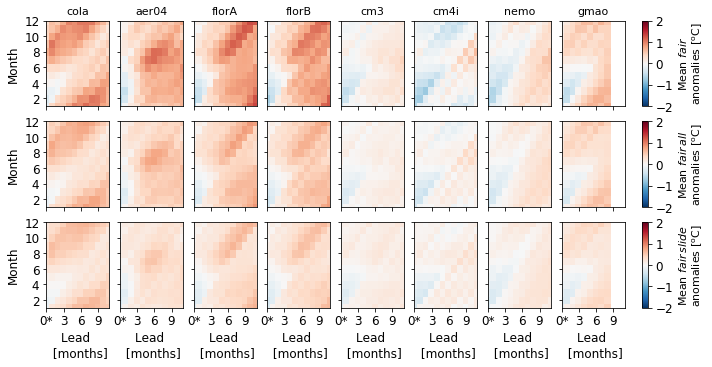

In [237]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    
    fig = plt.figure()
    grey = [0.8,0.8,0.8]
    
    models = fcst_nino34

    width = 0.095
    height = 0.17
    
    axes_locs = [[x, 0.8, width, height] for x in np.arange(1/(len(models)+1), 1, 1/(len(models)+1))] + \
                [[x, 0.6, width, height] for x in np.arange(1/(len(models)+1), 1, 1/(len(models)+1))] + \
                [[x, 0.4, width, height] for x in np.arange(1/(len(models)+1), 1, 1/(len(models)+1))]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))

    train_period = slice('1982','1998')
    test_period = slice('1999','2015')

    count = 0
    for model_name, model in models.items():
        fair = init_date_to_target_date(monthly_climatology(model['fair'].sel(init_date=test_period)), 
                                        init_date_coord='month')
        fair_slide = init_date_to_target_date(monthly_climatology(model['fair-sliding'].sel(init_date=test_period)), 
                                              init_date_coord='month')
        fair_all = init_date_to_target_date(monthly_climatology(model['fair-all'].sel(init_date=test_period)), 
                                            init_date_coord='month')

        ax0 = axes[count]
        ax1 = axes[count + len(models) ]
        ax2 = axes[count + 2*len(models) ]

        p1 = fair.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=-2, vmax=2, cmap='RdBu_r') 
        p2 = fair_all.plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=-2, vmax=2, cmap='RdBu_r') 
        p3 = fair_slide.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=-2, vmax=2, cmap='RdBu_r') 

        if count == (len(models)-1):
            ps = [p1, p2, p3]
            cax_y = [0.8, 0.6, 0.4,]
            label = ['Mean $fair$ \nanomalies [$^\mathrm{o}$C]',
                    'Mean $fair\, all$ \nanomalies [$^\mathrm{o}$C]',
                    'Mean $fair\, slide$ \nanomalies [$^\mathrm{o}$C]']
            for idc, p in enumerate(ps):
                cbaxes = fig.add_axes([1.01, cax_y[idc], 0.01, height]) 
                cb = plt.colorbar(p, cax = cbaxes)
                cb.set_label(label[idc], rotation=90, fontsize=fontsize-1)

        if (count == 0):
            ax0.set_yticks(np.arange(0,13,2))
            ax1.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax0.set_ylabel('Month')
            ax1.set_ylabel('Month')
            ax2.set_ylabel('Month')
        else:
            ax0.set_yticks(np.arange(0,13,2))
            ax1.set_yticks(np.arange(0,13,2))
            ax2.set_yticks(np.arange(0,13,2))
            ax0.set_yticklabels([])
            ax1.set_yticklabels([])
            ax2.set_yticklabels([])
            ax0.set_ylabel('')
            ax1.set_ylabel('')
            ax2.set_ylabel('')    

        ax0.set_xticks(np.arange(0,13,3))
        ax0.set_xticklabels([])
        ax0.set_xlabel('')
        ax1.set_xticks(np.arange(0,13,3))
        ax1.set_xticklabels([])
        ax1.set_xlabel('')
        ax2.set_xticks(np.arange(0,13,3))
        ax2.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
        ax2.set_xlabel('Lead \n [months]')
        ax0.set_title(model_name, fontsize=fontsize-1)

        ax0.set_xlim(0,11)
        ax1.set_xlim(0,11) 
        ax2.set_xlim(0,11)
        ax0.set_ylim(1,12)
        ax1.set_ylim(1,12) 
        ax2.set_ylim(1,12)
        
        count += 1

    # plt.savefig(saveloc + 'nino34_mean_anomalies.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_mean_anomalies.pdf', format='pdf', bbox_inches='tight')

# Plot schematic showing how onset and decay are defined

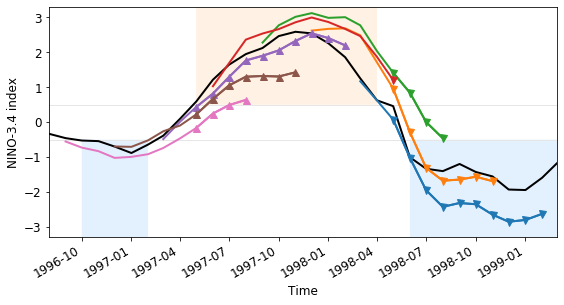

In [238]:
rc_params = {'figure.figsize'      : (8.0, 4.4),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):
    
    figure = plt.figure()
    grey = [0.9,0.9,0.9]

    fcst_dates = pd.date_range(start='1996-09', end='1998-03', freq='3MS')[::-1]
    fcst_to_plot = fcst_nino34['cm4i']
    
    (0.5+0*obs_nino34[anomaly_gp].sel(lead_time=0)).plot(color=grey, linestyle='-', linewidth=1, zorder=0)
    (-0.5+0*obs_nino34[anomaly_gp].sel(lead_time=0)).plot(color=grey, linestyle='-', linewidth=1, zorder=0)
    obs_nino34[anomaly_gp].sel(lead_time=0).plot(color='k', linestyle='-', label='Observations', zorder=0)

    plt.fill_between(obs_nino34[anomaly_gp].sel(lead_time=0).init_date.values,
                     100*obs_nino34[anomaly_gp].where(obs_where_elnino[anomaly_gp]).sel(lead_time=0),
                     0.5, #-100*obs_nino34[anomaly_gp].where(obs_where_elnino[anomaly_gp]).sel(lead_time=0),
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    plt.fill_between(obs_nino34[anomaly_gp].sel(lead_time=0).init_date.values,
                     100*obs_nino34[anomaly_gp].where(obs_where_lanina[anomaly_gp]).sel(lead_time=0),
                     -0.5, #-100*obs_nino34[anomaly_gp].where(obs_where_lanina[anomaly_gp]).sel(lead_time=0),
                     facecolor=upper_color, linewidth=0.0, zorder=0)

    for idx, date in enumerate(fcst_dates):
        plt.plot(doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).mean('ensemble'),
                 color=colors[idx], zorder=1, label='NMME individual model ensemble average')

    for idx, date in enumerate(fcst_dates):
        plt.plot(doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].where(obs_where_elnino_onset[anomaly_gp]).sel(init_date=date)).mean('ensemble'),
                 color=colors[idx], zorder=1, label='_nolegend_', marker='^', markersize=7)

    for idx, date in enumerate(fcst_dates):
        plt.plot(doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(fcst_to_plot[anomaly_gp].where(obs_where_elnino_decay[anomaly_gp]).sel(init_date=date)).mean('ensemble'),
                 color=colors[idx], zorder=1, label='_nolegend_', marker='v', markersize=7)

    # plt.plot(['1997-01','1999-01'],[0.5,0.5], zorder=0)
    # plt.plot(['2007','2012'],[-0.5,-0.5], zorder=0)
    plt.xlim('1996-08','1999-03')
    plt.ylim(-3.3,3.3);
    plt.xlabel('Time');
    plt.ylabel('NINO-3.4 index');
    plt.title('')

    plt.tight_layout();
    # plt.savefig(saveloc + 'nino34_onset_schematic.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_onset_schematic.pdf', format='pdf', bbox_inches='tight')

# What about **onset** of El Nino and La Nina?

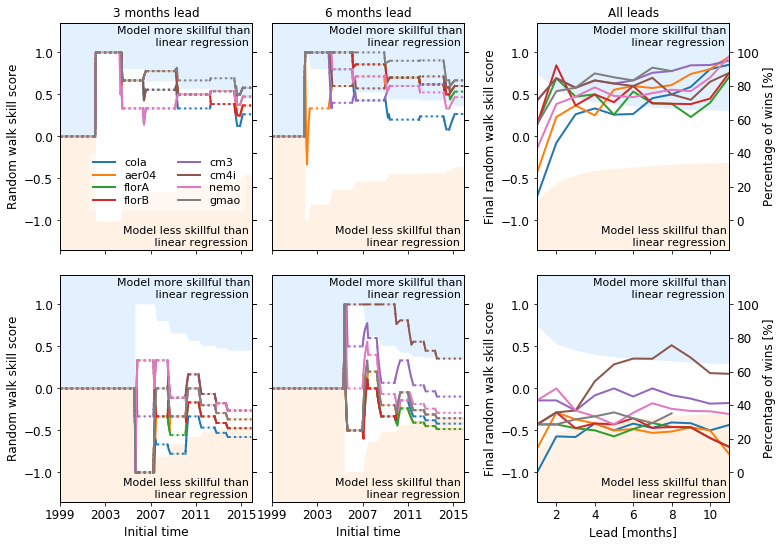

In [239]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    grey = 'w' #[0.9,0.9,0.9]

    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    leads = [3, 6]
    masks = [obs_where_elnino_onset,
             obs_where_lanina_onset]
#     models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
#     model_name = ['cola','aer04','florA','florB','cm3','cm4']
    models = fcst_nino34
    
    base = regr_nino34['linear regression']

    count = 0
    for idx, mask in enumerate(masks):
        col_n = 0
        for model_name, model in models.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                    model[anomaly_gp].mean('ensemble').where(mask[anomaly_gp]), 
                                                    obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
                norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

                if col_n == 0:
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

                ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                        label='_nolegend_', color=colors[col_n], alpha=0.1)
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==0) | (mask[anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                        label='_nolegend_', color=colors[col_n], linestyle=':')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==1) | (mask[anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                        label=model_name, linestyle='-', color=colors[col_n])

                ax.set_xlim('1999','2016')
                ax.set_xticks(['1999','2003','2007','2011','2015'])
                ax.set_xticklabels(['1999','2003','2007','2011','2015'])
                if axI < len(leads) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('Random walk skill score')
                if count == 0:
                    ax.set_title(str(lead) + ' months lead')

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(0-0.35/2, 1+0.35/2)
                ax2.set_yticks(np.arange(0,1.1,0.2))
                ax2.set_yticklabels([])
                # ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1.35,1.35)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if col_n == 0:
                    ax.text('2004-01',1.08,'Model more skillful than \n           linear regression', fontsize=11)
                    ax.text('2004-08',-1.3,'Model less skillful than \n         linear regression', fontsize=11)

                if (count == 0) & (idz == 0) & (col_n == len(models)-1):
                    legend = ax.legend(ncol=2, fontsize=11, loc='lower right', bbox_to_anchor=[0,0.15,0.99,1], framealpha=0.5)
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]

            sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                model[anomaly_gp].mean('ensemble').where(mask[anomaly_gp]), 
                                                obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
            norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

            if col_n == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                (conf_plot).sel(init_date='2015-12-01'), color=grey, label='_nolegend_')

            ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), 
                    label=model_name, linestyle='-', color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if col_n == 0:
                ax.text(3.9,1.08,'Model more skillful than \n           linear regression', fontsize=11)
                ax.text(4.3,-1.3,'Model less skillful than \n         linear regression', fontsize=11)

            ax.set_ylim(-1.35,1.35)
            ax.set_ylabel('Final random walk skill score')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads')
                
            col_n += 1

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0-0.35/2, 1+0.35/2)
        ax2.set_yticks(np.arange(0,1.1,0.2))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1

    # plt.savefig(saveloc + 'nino34_linR_onset.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_linR_onset.pdf', format='pdf', bbox_inches='tight')

# And for categorical forecasts (relative to ordered logistic regression)?

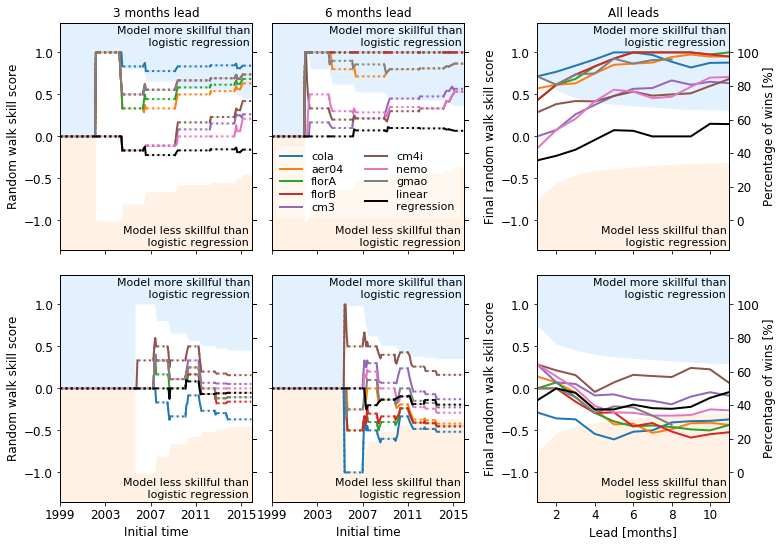

In [240]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    grey = 'w' #[0.9,0.9,0.9]

    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    leads = [3, 6]
    masks = [obs_where_elnino_onset,
             obs_where_lanina_onset]
#     models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
#     model_name = ['cola','aer04','florA','florB','cm3','cm4']
    models = {**fcst_where_event, **{'linear regression': regr_where_event['linear regression']}}
    
    base = regr_nino34['logistic regression']

    count = 0
    for idx, mask in enumerate(masks):
        col_n = 0
        for model_name, model in models.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                    model[anomaly_gp].where(mask[anomaly_gp]), 
                                                    obs_where_event[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
                norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

                if col_n == 0:
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

                if model_name == 'linear regression':
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                            label='_nolegend_', color='k', alpha=0.1)
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==0) | (mask[anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                            label='_nolegend_', color='k', linestyle=':')
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==1) | (mask[anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                            label='linear \nregression', linestyle='-', color='k')
                else:
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                            label='_nolegend_', color=colors[col_n], alpha=0.1)
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==0) | (mask[anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                            label='_nolegend_', color=colors[col_n], linestyle=':')
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==1) | (mask[anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                            label=model_name, linestyle='-', color=colors[col_n])

                ax.set_xlim('1999','2016')
                ax.set_xticks(['1999','2003','2007','2011','2015'])
                ax.set_xticklabels(['1999','2003','2007','2011','2015'])
                if axI < len(leads) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('Random walk skill score')
                if count == 0:
                    ax.set_title(str(lead) + ' months lead')

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(0-0.35/2, 1+0.35/2)
                ax2.set_yticks(np.arange(0,1.1,0.2))
                ax2.set_yticklabels([])
                # ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1.35,1.35)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if col_n == 0:
                    ax.text('2004-01',1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
                    ax.text('2004-08',-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

                if (count == 0) & (idz == 1) & (col_n == len(models)-1):
                    legend = ax.legend(ncol=2, fontsize=11, loc='lower right', bbox_to_anchor=[0.01,0.12,0.99,1], framealpha=0.5)
                    legend.get_frame().set_facecolor('w')
                    legend.get_frame().set_edgecolor('w')

            ax = axes[axI+1]

            sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                model[anomaly_gp].where(mask[anomaly_gp]), 
                                                obs_where_event[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
            norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

            if col_n == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                (conf_plot).sel(init_date='2015-12-01'), color=grey, label='_nolegend_')

            if model_name == 'linear regression':
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), 
                        label=model_name, linestyle='-', color='k')
            else:
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), 
                        label=model_name, linestyle='-', color=colors[col_n])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if col_n == 0:
                ax.text(3.9,1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
                ax.text(4.3,-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

            ax.set_ylim(-1.35,1.35)
            ax.set_ylabel('Final random walk skill score')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads')
                
            col_n += 1

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0-0.35/2, 1+0.35/2)
        ax2.set_yticks(np.arange(0,1.1,0.2))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1

    # plt.savefig(saveloc + 'nino34_olog_onset.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_olog_onset.pdf', format='pdf', bbox_inches='tight')

# What about **decay** of El Nino and La Nina?

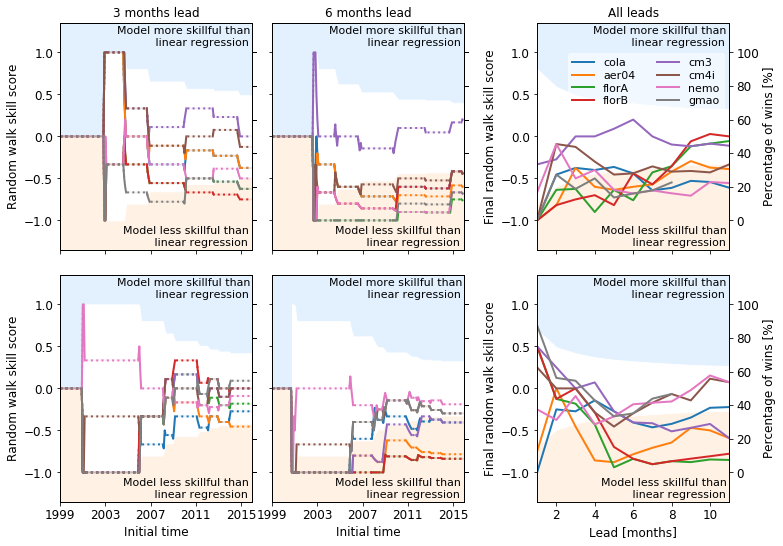

In [241]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    grey = 'w' #[0.9,0.9,0.9]

    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    leads = [3, 6]
    masks = [obs_where_elnino_decay,
             obs_where_lanina_decay]
    models = fcst_nino34
    
    base = regr_nino34['linear regression']

    count = 0
    for idx, mask in enumerate(masks):
        col_n = 0
        for model_name, model in models.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                    model[anomaly_gp].mean('ensemble').where(mask[anomaly_gp]), 
                                                    obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
                norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

                if col_n == 0:
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

                ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                        label='_nolegend_', color=colors[col_n], alpha=0.1)
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==0) | (mask[anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                        label='_nolegend_', color=colors[col_n], linestyle=':')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==1) | (mask[anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                        label=model_name, linestyle='-', color=colors[col_n])

                ax.set_xlim('1999','2016')
                ax.set_xticks(['1999','2003','2007','2011','2015'])
                ax.set_xticklabels(['1999','2003','2007','2011','2015'])
                if axI < len(leads) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('Random walk skill score')
                if count == 0:
                    ax.set_title(str(lead) + ' months lead')

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(0-0.35/2, 1+0.35/2)
                ax2.set_yticks(np.arange(0,1.1,0.2))
                ax2.set_yticklabels([])
                # ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1.35,1.35)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if col_n == 0:
                    ax.text('2004-01',1.08,'Model more skillful than \n           linear regression', fontsize=11)
                    ax.text('2004-08',-1.3,'Model less skillful than \n         linear regression', fontsize=11)

            ax = axes[axI+1]

            sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                model[anomaly_gp].mean('ensemble').where(mask[anomaly_gp]), 
                                                obs_nino34[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
            norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

            if col_n == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                (conf_plot).sel(init_date='2015-12-01'), color=grey, label='_nolegend_')

            ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), 
                    label=model_name, linestyle='-', color=colors[col_n])
            
            if (count == 0) & (col_n == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=11, loc='upper right', bbox_to_anchor=[0.01,0,0.99,0.89], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if col_n == 0:
                ax.text(3.9,1.08,'Model more skillful than \n           linear regression', fontsize=11)
                ax.text(4.3,-1.3,'Model less skillful than \n         linear regression', fontsize=11)

            ax.set_ylim(-1.35,1.35)
            ax.set_ylabel('Final random walk skill score')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads')
                
            col_n += 1

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0-0.35/2, 1+0.35/2)
        ax2.set_yticks(np.arange(0,1.1,0.2))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1

    # plt.savefig(saveloc + 'nino34_linR_decay.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_linR_decay.pdf', format='pdf', bbox_inches='tight')

# And for categorical forecasts (relative to ordered logistic regression)?

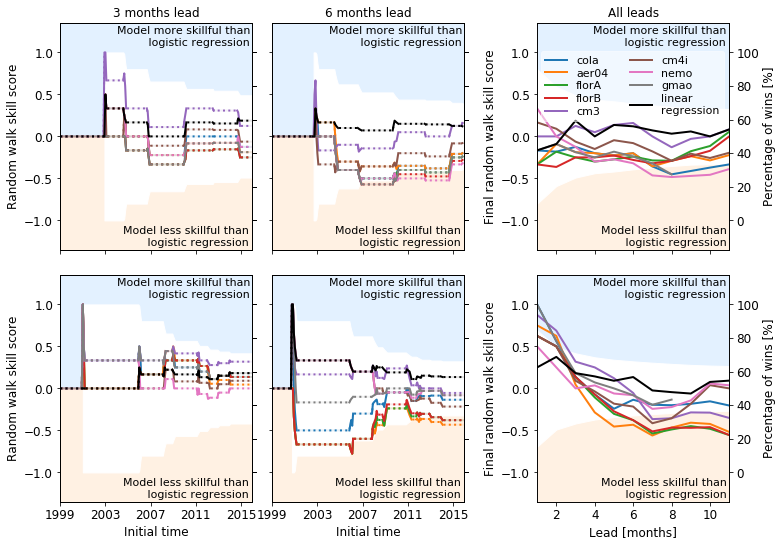

In [242]:
rc_params = {'figure.figsize'      : (9.2, 7.0),
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 2.0}
    
with mpl.rc_context(rc=rc_params):

    fig = plt.figure()
    grey = 'w' #[0.9,0.9,0.9]

    axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
                [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
    axes=[]
    for axes_loc in axes_locs:
        axes.append(fig.add_axes(axes_loc))
    # axes = fig.subplots(nrows=2, ncols=3)

    leads = [3, 6]
    masks = [obs_where_elnino_decay,
             obs_where_lanina_decay]
#     models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
#     model_name = ['cola','aer04','florA','florB','cm3','cm4']
    models = {**fcst_where_event, **{'linear regression': regr_where_event['linear regression']}}
    
    base = regr_nino34['logistic regression']

    count = 0
    for idx, mask in enumerate(masks):
        col_n = 0
        for model_name, model in models.items():
            for idz, lead in enumerate(leads):
                axI = idx * len(leads) + idz + count
                ax = axes[axI]
                sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                    model[anomaly_gp].where(mask[anomaly_gp]), 
                                                    obs_where_event[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
                norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

                if col_n == 0:
                    conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                    ax.fill_between(conf.init_date.values,
                                    (-1 * conf_plot).sel(lead_time=lead), 
                                    (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

                if model_name == 'linear regression':
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                            label='_nolegend_', color='k', alpha=0.1)
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==0) | (mask[anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                            label='_nolegend_', color='k', linestyle=':')
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==1) | (mask[anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                            label='linear \nregression', linestyle='-', color='k')
                else:
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                            label='_nolegend_', color=colors[col_n], alpha=0.1)
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==0) | (mask[anomaly_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                            label='_nolegend_', color=colors[col_n], linestyle=':')
                    ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[anomaly_gp]==1) | (mask[anomaly_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                            label=model_name, linestyle='-', color=colors[col_n])

                ax.set_xlim('1999','2016')
                ax.set_xticks(['1999','2003','2007','2011','2015'])
                ax.set_xticklabels(['1999','2003','2007','2011','2015'])
                if axI < len(leads) + 1:
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel('Initial time')
                if idz == 0:
                    ax.set_ylabel('Random walk skill score')
                if count == 0:
                    ax.set_title(str(lead) + ' months lead')

                ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.set_ylim(0-0.35/2, 1+0.35/2)
                ax2.set_yticks(np.arange(0,1.1,0.2))
                ax2.set_yticklabels([])
                # ax2.set_ylabel('Percentage of wins [%]')

                ax.set_ylim(-1.35,1.35)
                if idz > 0:
                    ax.set_yticklabels([])

                # Shade regions ------
                ymin, ymax = ax.get_ylim()
                xmin, xmax = ax.get_xlim()
                ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                                 facecolor=upper_color, linewidth=0.0, zorder=0)
                ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                                 facecolor=lower_color, linewidth=0.0, zorder=0)
                if col_n == 0:
                    ax.text('2004-01',1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
                    ax.text('2004-08',-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

            ax = axes[axI+1]

            sign, conf = doppyo.skill.sign_test(base[anomaly_gp].where(mask[anomaly_gp]), 
                                                model[anomaly_gp].where(mask[anomaly_gp]), 
                                                obs_where_event[anomaly_gp].sel(init_date=slice('1999','2015')).where(mask[anomaly_gp]))
            norm = (1 + 0*sign.where(mask[anomaly_gp])).cumsum('init_date')

            if col_n == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.lead_time.values,
                                (-1 * conf_plot).sel(init_date='2015-12-01'), 
                                (conf_plot).sel(init_date='2015-12-01'), color=grey, label='_nolegend_')

            if model_name == 'linear regression':
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), 
                        label='linear \nregression', linestyle='-', color='k')
            else:
                ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), 
                        label=model_name, linestyle='-', color=colors[col_n])
                
            if (count == 0) & (col_n == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=11, loc='upper right', bbox_to_anchor=[0.01,0,0.99,0.9], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if col_n == 0:
                ax.text(3.9,1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
                ax.text(4.3,-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

            ax.set_ylim(-1.35,1.35)
            ax.set_ylabel('Final random walk skill score')
            ax.set_xlim(1,11)
            ax.set_xticks(np.arange(2,12,2))
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Lead [months]')
            if idx == 0:
                ax.set_title('All leads')
                
            col_n += 1

        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim(0-0.35/2, 1+0.35/2)
        ax2.set_yticks(np.arange(0,1.1,0.2))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')

        count += 1

    # plt.savefig(saveloc + 'nino34_olog_decay.eps', format='eps', bbox_inches='tight')
    plt.savefig(saveloc + 'nino34_olog_decay.pdf', format='pdf', bbox_inches='tight')